# Imports

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
from numpy.random import random, seed
import matplotlib as mpl
from matplotlib import pyplot as plt
import csv
from scipy.stats import chi2_contingency
import numpy.random as rng
from scipy.signal import lombscargle

mpl.rcParams['figure.dpi'] = 150/1.25
plt.style.use('ggplot')

# Variables

| File Name | Stellar Mass $(M_*/M_{\odot})$ |  $M \sin I (M_\text{Jupiter})$ | Semi-major Axis (AU) |P (days)|
|     ---     |              ---             |         ---                    |      ---      | --- |
|`star-00.dat`|             1.04             | 2.104795819276726e+25                               |      0.6170484692982672         |   4.230829397625029   |
|`star-01.dat`|             1.17             |     9.93646903545315e+25                           |      8.801232127421299         |   227.90917419969932   |
|`star-02.dat`|             1.51             |                                |               |      |
|`star-03.dat`|             1.47             |                                |               |      |
|`star-04.dat`|             0.85             |                                |               |      |
|`star-05.dat`|             1.23             |                                |               |      |
|`star-06.dat`|             0.83             |                                |               |      |
|`star-07.dat`|             1.24             |                                |               |      |

In [2]:
star = 'star-00'
m_star = 1.04
G = 6.67430*10**-11
# Newton-Raphson stuff
max_iter = 20  # Max iterations
tol = 1E-12  # Tolerance
# mcmc variables & Range Cutters
n_steps = 500_000
the_seed = 3
beta = 3 #acceptance parameter
RCv = 10
RCk = 10
RCt = 100
RCp = 1000
sigfig = 10
RCe = 1000
RCw = 50
odds_counter = 0
changes_counter = 0 # could implement this later to semi automate range cutters by evaluating quality of mcmc through change of variable count.
# Take random curves from the posterior
n_curves = 200
spacing = 5
eccentricity = False

# The HeavyLifting

data points: 202


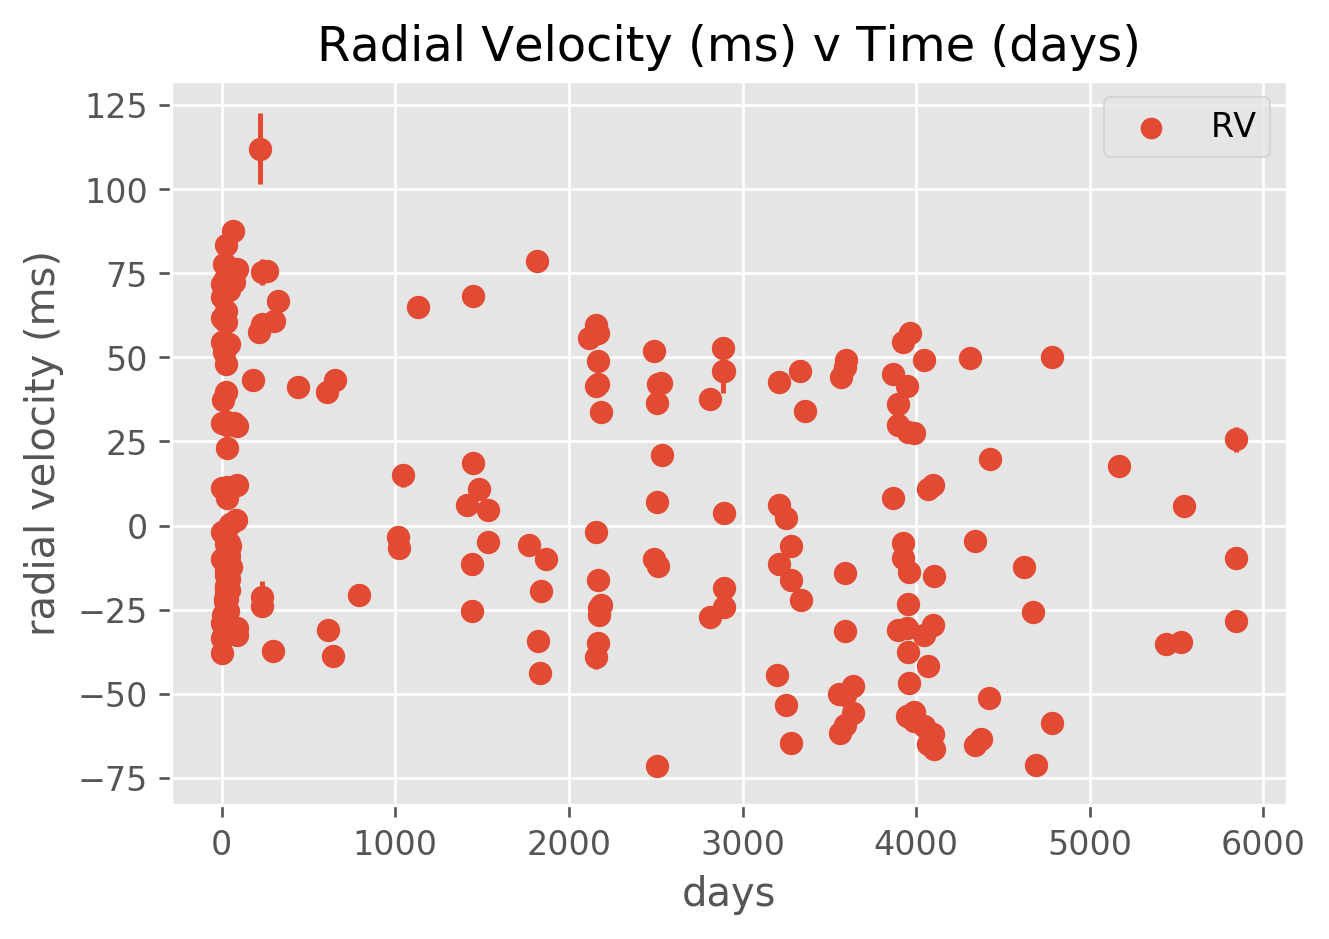

In [3]:
from tqdm.notebook import tqdm

data = np.loadtxt(f'{star}.dat')

x = []
y = []
errors = []

for i in range (0,len(data)):
    x.append(data[i][0])
    y.append(data[i][1])
    errors.append(data[i][2])

print(f'data points: {len(x)}')
# fix x axis

x = np.array(x)
x = x - x[0]

x_data = x
y_data = y
error_data = errors
# plot the data again

plt.scatter(x,y,label='RV')
plt.errorbar(x,y,yerr = errors,fmt='o')
plt.xlabel('days')
plt.ylabel('radial velocity (ms)')
plt.title('Radial Velocity (ms) v Time (days)')
plt.legend()
plt.show()

In [4]:
# circular radial velocity
def circ_rv(v_o,T_p,K,P,t):
    v_r = v_o + K*np.cos((2*np.pi*(t-T_p))/(P))
    return v_r

# returns elliptic radial velocity
def ellip_rv(v_o,K,w,e,t,t_p,P):
    f_a = true_anomaly(E,e)
    v_r = v_o + K*np.cos(f_a+w) + e*np.cos(w)
    return v_r

# mean anomaly, m
def mean_anomaly(P,t,t_p):
    return ((2*np.pi)/P)*(t-t_p)

# Define the function for which we want to find the root
def f(E,e,M):
    return (E - e*math.sin(E) - M)

# Define the derivative of the function
def f_prime(E,e):
    return (1 - e*math.cos(E))

# Iterating until either the tolerance or max iterations is met
def newt_loop(tol,max_iter,innit,e):
    x0 = innit
    xi_1 = x0
    i = 0
    while abs(f(xi_1,e,M)) > tol and i > max_iter:
        i = i + 1
        xi = xi_1-f(xi_1,e,M)/f_prime(xi_1,e)  # Newton-Raphson equation
        xi_1 = xi

    return (xi_1,f(xi_1,e,M))

def newt_step(xi,e,M):
    x = xi-f(xi,e,M)/f_prime(xi,e)
    return x

# true anomaly f
def true_anomaly(E, e):
    # Calculate the cosine and sine parts of the true anomaly
    cos_f = (math.cos(E) - e) / (1 - e*math.cos(E))
    sin_f = (math.sqrt(1 - e**2) * math.sin(E)) / (1 - e*math.cos(E))
    f = np.arctan2(sin_f,cos_f)
    return f

# chi squared
def weighted_chi2_errors(fit_y,y_data,y_err):
    return float((1/len(fit_y))*sum(((np.array(fit_y)-np.array(y_data))/y_err)**2))

def radial(a, e, f):
    # Calculate the radial distance
    r = a*(1 - e**2)/(1 + e*math.cos(f))
    return r

def cartesian(r,f):
    # Calculate the cartesian coordinates
    x = r*math.cos(f)
    y = r*math.sin(f)
    return x, y

def Lombscargol(x,y,errors,xlabel,ylabel,Fmin=1 / 1000000,Fmax=100):
    # generate data and compute the periodogram
    freq, PLS = LombScargle(x, y, errors).autopower(minimum_frequency=1 / 1000000,
                                                   maximum_frequency=100)
    best_freq = freq[np.argmax(PLS)]
    phase = (x * best_freq) % 1

    # compute the best-fit model
    phase_fit = np.linspace(0, 1)
    mag_fit = LombScargle(x, y, errors).model(t=phase_fit / best_freq,
                                              frequency=best_freq)

    # set up the figure & axes for plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
    inset = fig.add_axes([0.78, 0.56, 0.15, 0.3])

    # plot the raw data
    ax[0].errorbar(x, y, errors, fmt='ok', elinewidth=1.5, capsize=0)
    ax[0].invert_yaxis()
    ax[0].set(
              xlabel=xlabel,
              ylabel=ylabel)

    # plot the periodogram
    ax[1].plot(1. / freq, PLS)
    ax[1].set(xlim=(-10,1/best_freq*10),
              xlabel='period (days)',
              ylabel='Lomb-Scargle Power',)

    # plot the phased data & model in the inset
    inset.errorbar(phase, y, errors, fmt='.k', capsize=0)
    inset.plot(phase_fit, mag_fit)
    inset.invert_yaxis()
    inset.set_xlabel('phase')
    inset.set_ylabel('mag')
    plt.show()
    print(f'Suggested period: {1/best_freq:.5f} days')
    Pguess = 1 / best_freq


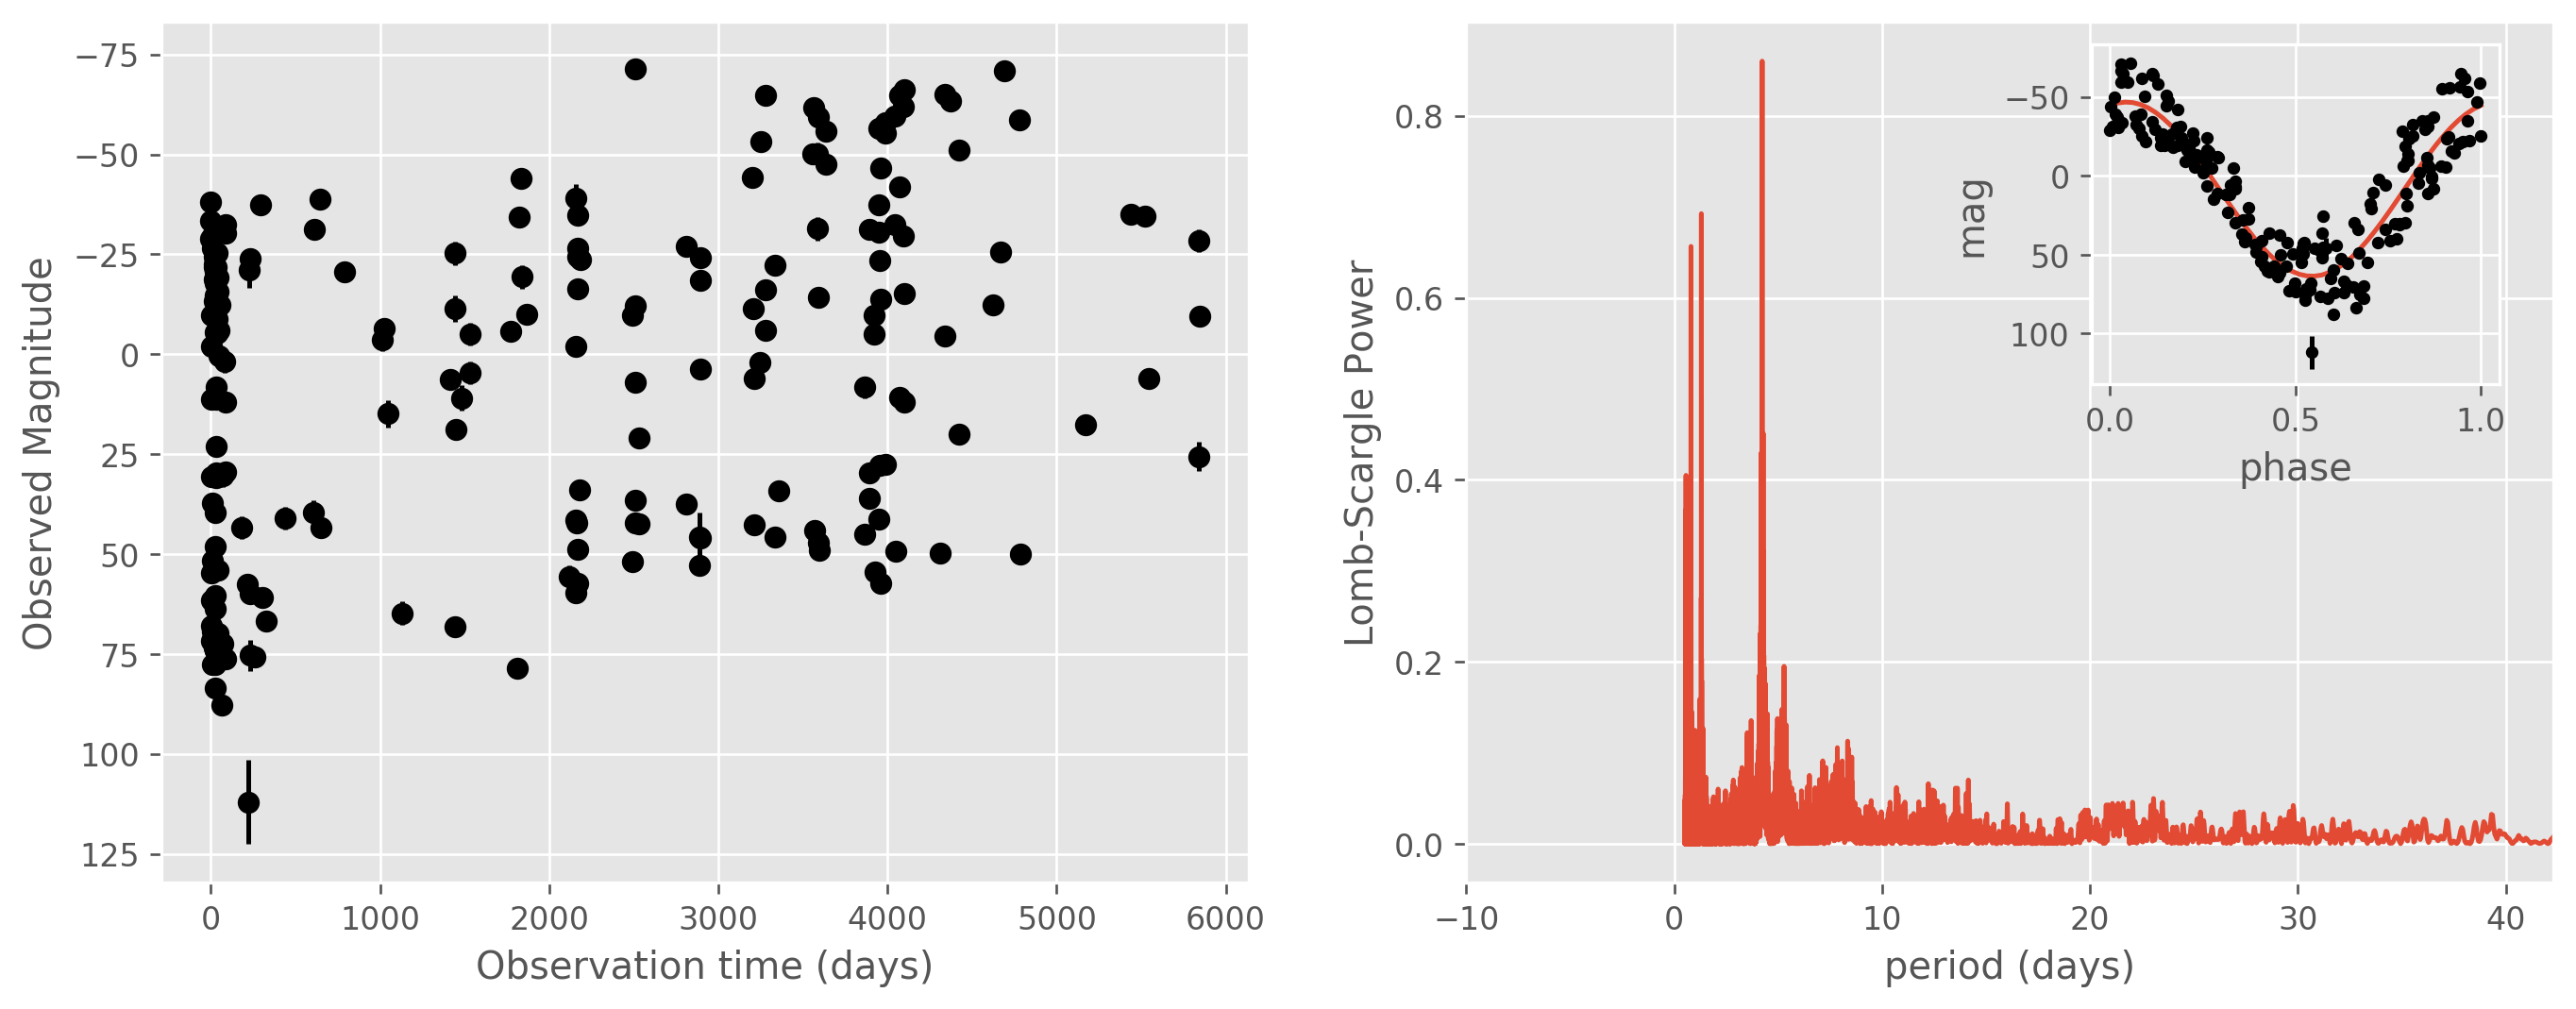

Suggested period: 4.23097 days


In [5]:
import math

from astropy.timeseries import LombScargle

# generate data and compute the periodogram
freq, PLS = LombScargle(x, y, errors).autopower(minimum_frequency=1 / 100000,
                                               maximum_frequency=1 / 0.5)
best_freq = freq[np.argmax(PLS)]
phase = (x * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1)
mag_fit = LombScargle(x, y, errors).model(t=phase_fit / best_freq,
                                          frequency=best_freq)

# set up the figure & axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
inset = fig.add_axes([0.78, 0.56, 0.15, 0.3])

# plot the raw data
ax[0].errorbar(x, y, errors, fmt='ok', elinewidth=1.5, capsize=0)
ax[0].invert_yaxis()
ax[0].set(
          xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

# plot the periodogram
ax[1].plot(1. / freq, PLS)
ax[1].set(xlim=(-10,1/best_freq*10),
          xlabel='period (days)',
          ylabel='Lomb-Scargle Power',)

# plot the phased data & model in the inset
inset.errorbar(phase, y, errors, fmt='.k', capsize=0)
inset.plot(phase_fit, mag_fit)
inset.invert_yaxis()
inset.set_xlabel('phase')
inset.set_ylabel('mag')
plt.show()
print(f'Suggested period: {1/best_freq:.5f} days')
Pguess = 1 / best_freq
#Pguess = 500

(271.63155377449357, 4.230973334098533, 6.461396256297222, 2.2917772226367057, 91.7356987002)
Current chi: 271.63155377449357


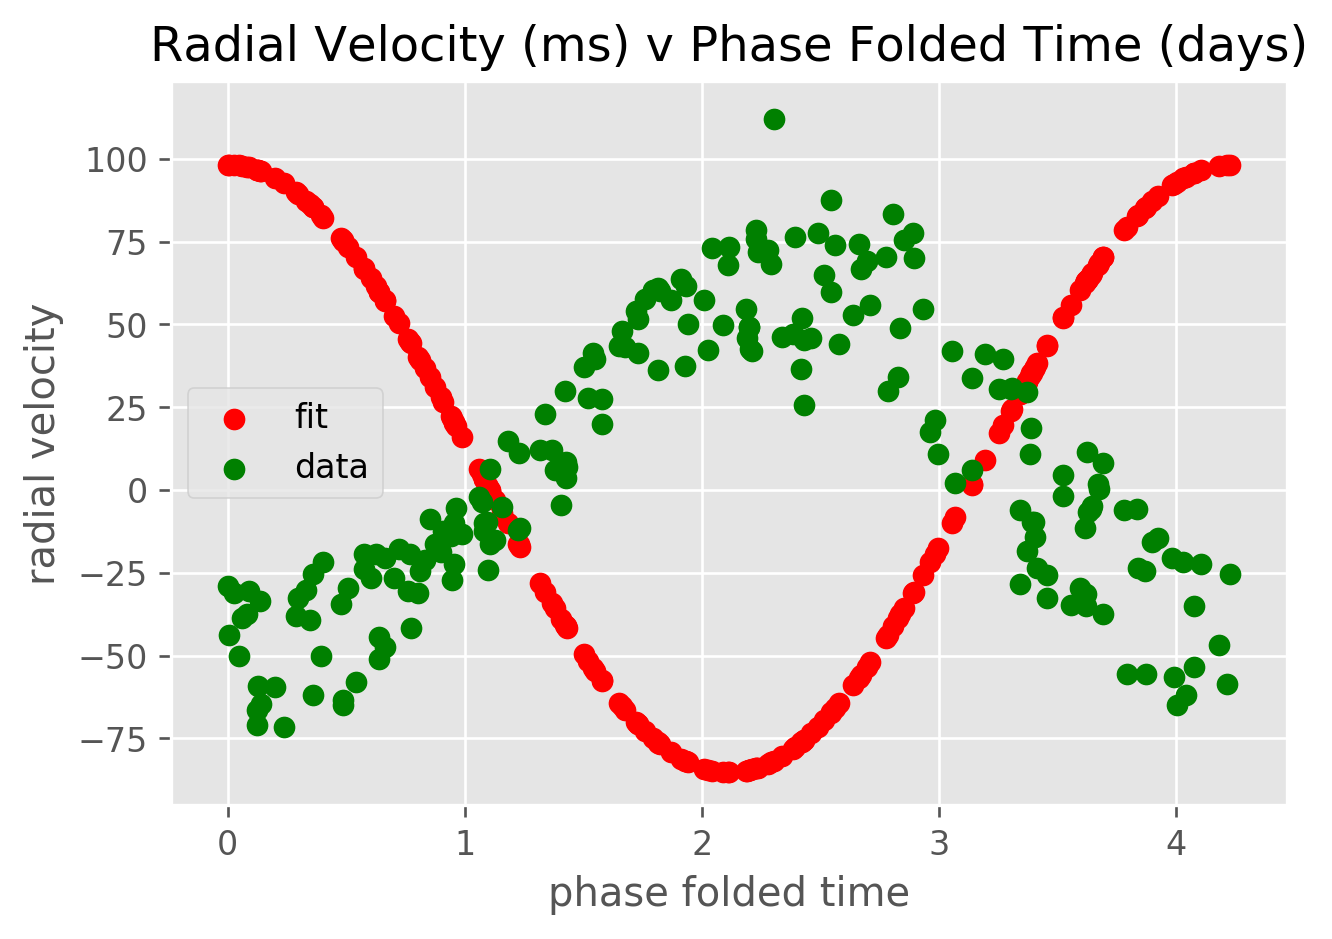

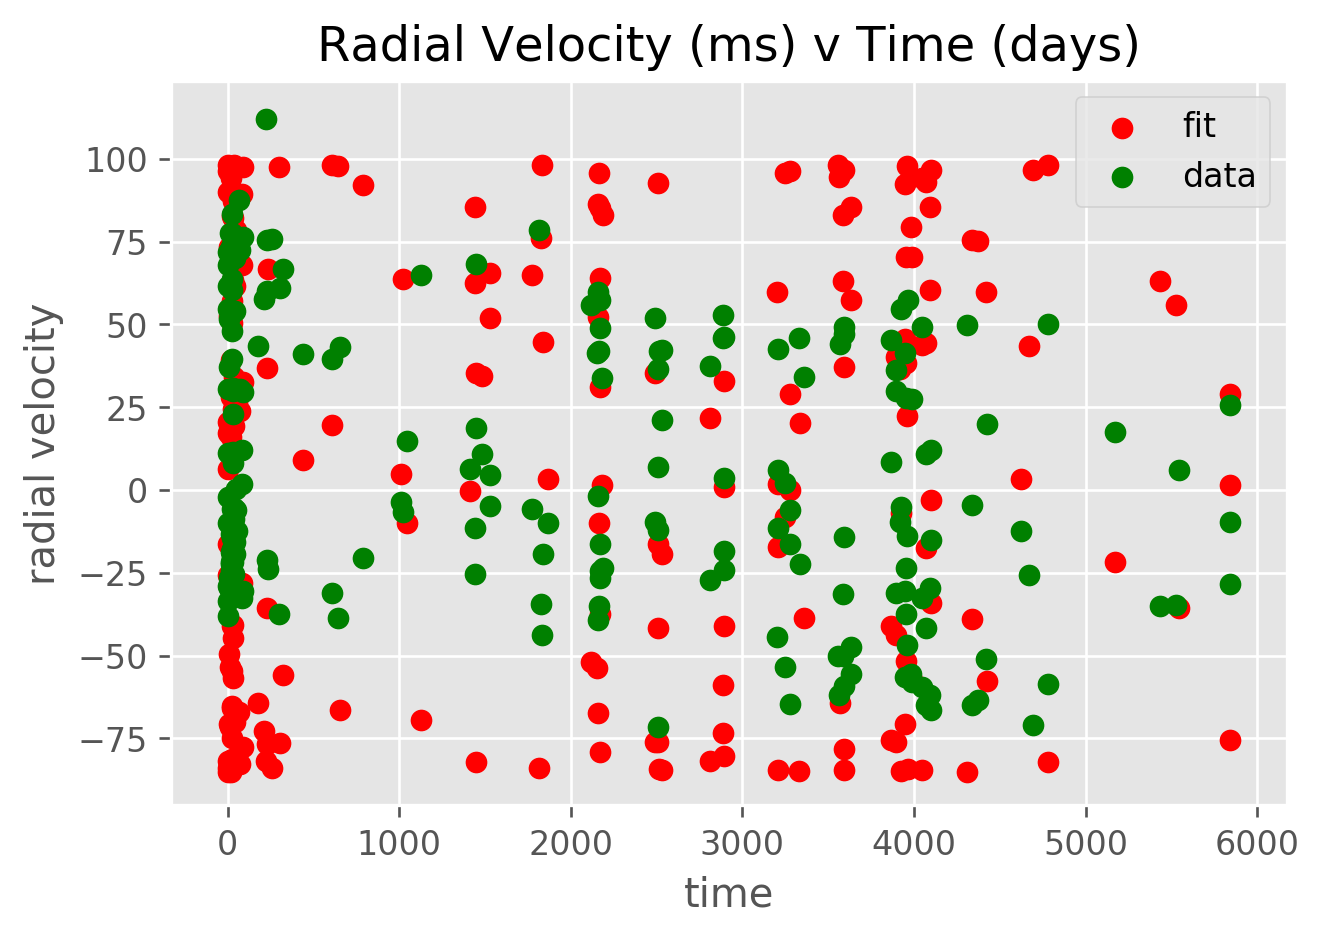

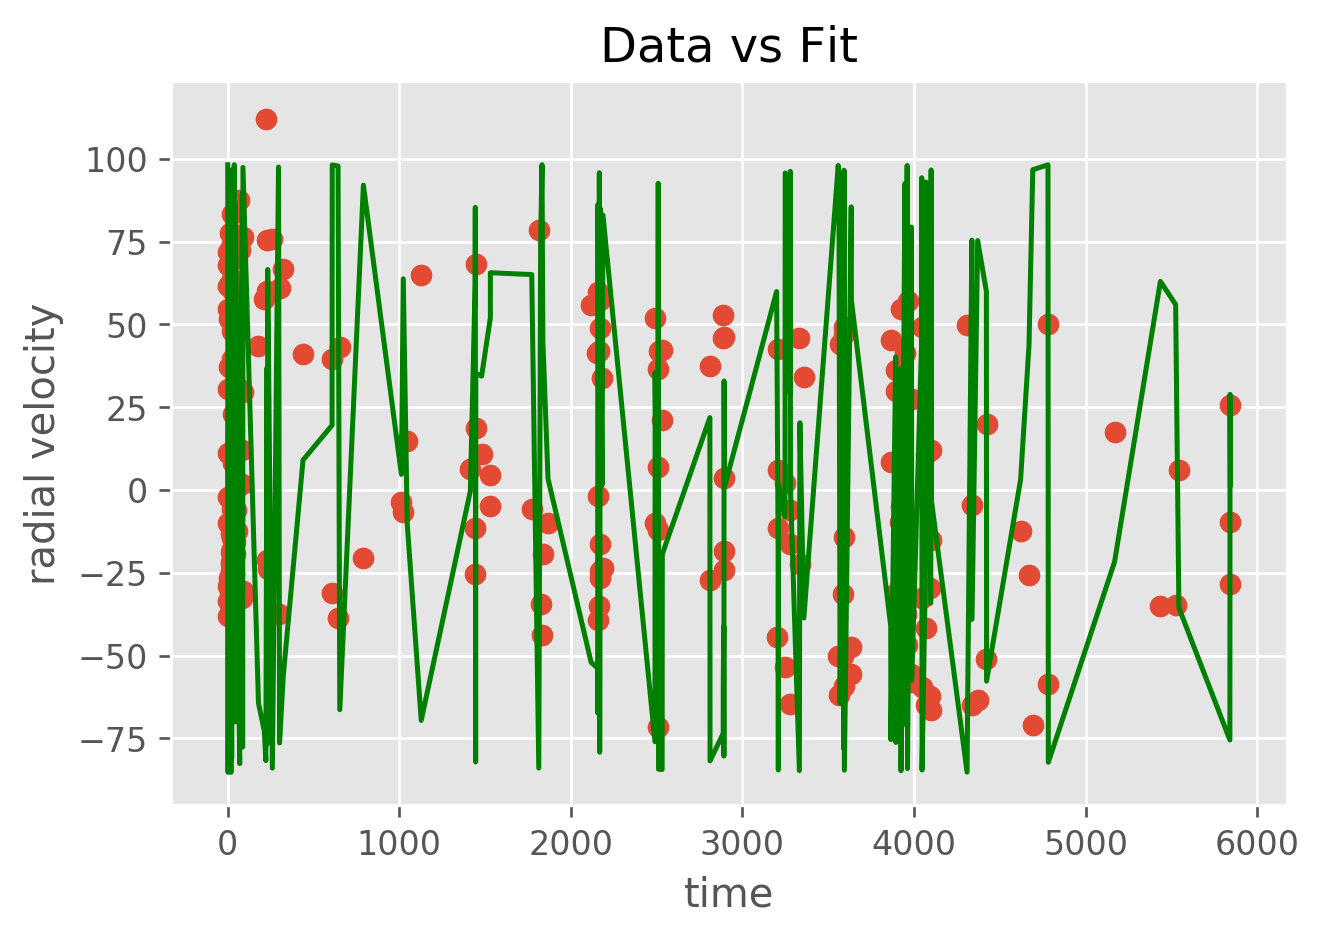

<Figure size 720x480 with 0 Axes>

In [6]:
if eccentricity == True:

    e_guesses = np.linspace(0,0.99,25)
    w_guesses = np.linspace(0,np.pi*2,25)
    tp_guesses = np.linspace(0,Pguess,25)

    e = e_guesses[0]
    w = w_guesses[0]
    t_p = tp_guesses[0]

    v_o,K= np.mean(y),(np.max(y)-np.min(y))*0.5


    r_v = []
    for j in x:
        M = mean_anomaly(Pguess,j,t_p)
        i = 0
        xi = M
        yy = abs(f(xi,e,M))
        while yy > tol and i < max_iter:
            xi = newt_step(xi,e,M)
            yy = abs(f(xi,e,M))
            i += 1
        E = xi
        f_a = true_anomaly(E,e)
        r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))

    chi = weighted_chi2_errors(r_v,y,errors)
    print('pre MCMC chi', chi)

    for ii in e_guesses:
        for jj in w_guesses:
            for kk in tp_guesses:
                initial_guesses = Pguess,np.mean(y),(np.max(y)-np.min(y))*0.5,kk,jj,ii
                Pguess,v_o,K,kk,jj,ii = initial_guesses

                tfolded = x%Pguess

                r_v = []
                for j in x:
                    M = mean_anomaly(Pguess,j,kk)
                    i = 0
                    xi = M
                    yy = abs(f(xi,e,M))
                    while yy > tol and i < max_iter:
                        xi = newt_step(xi,e,M)
                        yy = abs(f(xi,e,M))
                        i += 1
                    E = xi
                    f_a = true_anomaly(E,ii)
                    r_v.append(ellip_rv(v_o,K,jj,ii,j,kk,Pguess))

                new_chi = weighted_chi2_errors(r_v,y,errors)

                if new_chi < chi:
                    chi = new_chi
                    best_e = ii
                    best_w = jj
                    best_tp = kk

    e = best_e
    w = best_w
    t_p = best_tp

    r_v = []
    for j in x:
        M = mean_anomaly(Pguess,j,t_p)
        E,check = newt_loop(tol,max_iter,M,e)
        f_a = true_anomaly(E,e)
        r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))

    pre_mcmc = chi,Pguess,v_o,t_p,K,e,w

if eccentricity == False:

    tfolded = x%Pguess
    v_o = np.mean(y)
    K = (np.max(y)-np.min(y))*0.5
    tp_guesses = np.linspace(0,Pguess,25)
    tptp = tp_guesses[0]

    r_v = circ_rv(v_o,tptp,K,Pguess,x)
    chi = weighted_chi2_errors(r_v,y,errors)


    for tptp in tp_guesses:

        r_v = circ_rv(v_o,tptp,K,Pguess,x)
        new_chi = weighted_chi2_errors(r_v,y,errors)
        if new_chi < chi:
            chi = new_chi
            best_tp = tptp

    t_p = best_tp

    pre_mcmc = chi,Pguess,v_o,t_p,K
print(pre_mcmc)
plt.scatter(tfolded,r_v,label='fit',color='red')
plt.scatter(tfolded,y,label='data',color='green')
plt.xlabel('phase folded time')
plt.ylabel('radial velocity')
plt.title('Radial Velocity (ms) v Phase Folded Time (days)')
plt.legend()

plt.figure()

plt.scatter(x,r_v,label='fit',color='red')
plt.scatter(x,y,label='data',color='green')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.title('Radial Velocity (ms) v Time (days)')
plt.legend()

plt.figure()

plt.plot(x,r_v,'g-',label = 'fit')
plt.scatter(x,y,label='data')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.title('Data vs Fit')

plt.figure()

print(f'Current chi: {chi}')

P:4.230973334098533,K:91.7356987002,t_p:2.2917772226367057,v_o:6.461396256297222
0.0%
10.0%
20.0%
30.0%


40.0%
50.0%


60.0%
70.0%
80.0%


No handles with labels found to put in legend.


90.0%


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


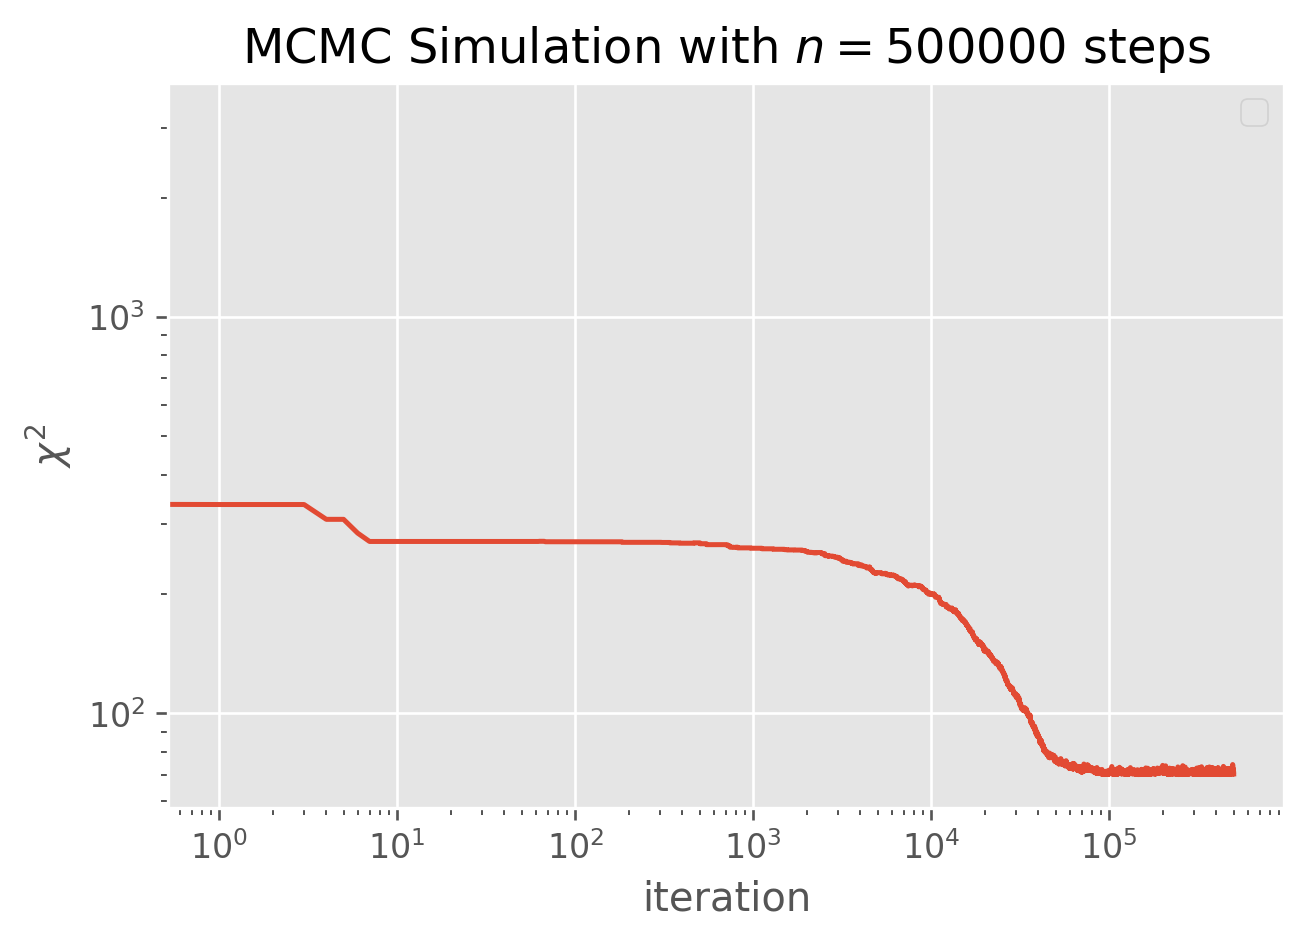

No handles with labels found to put in legend.


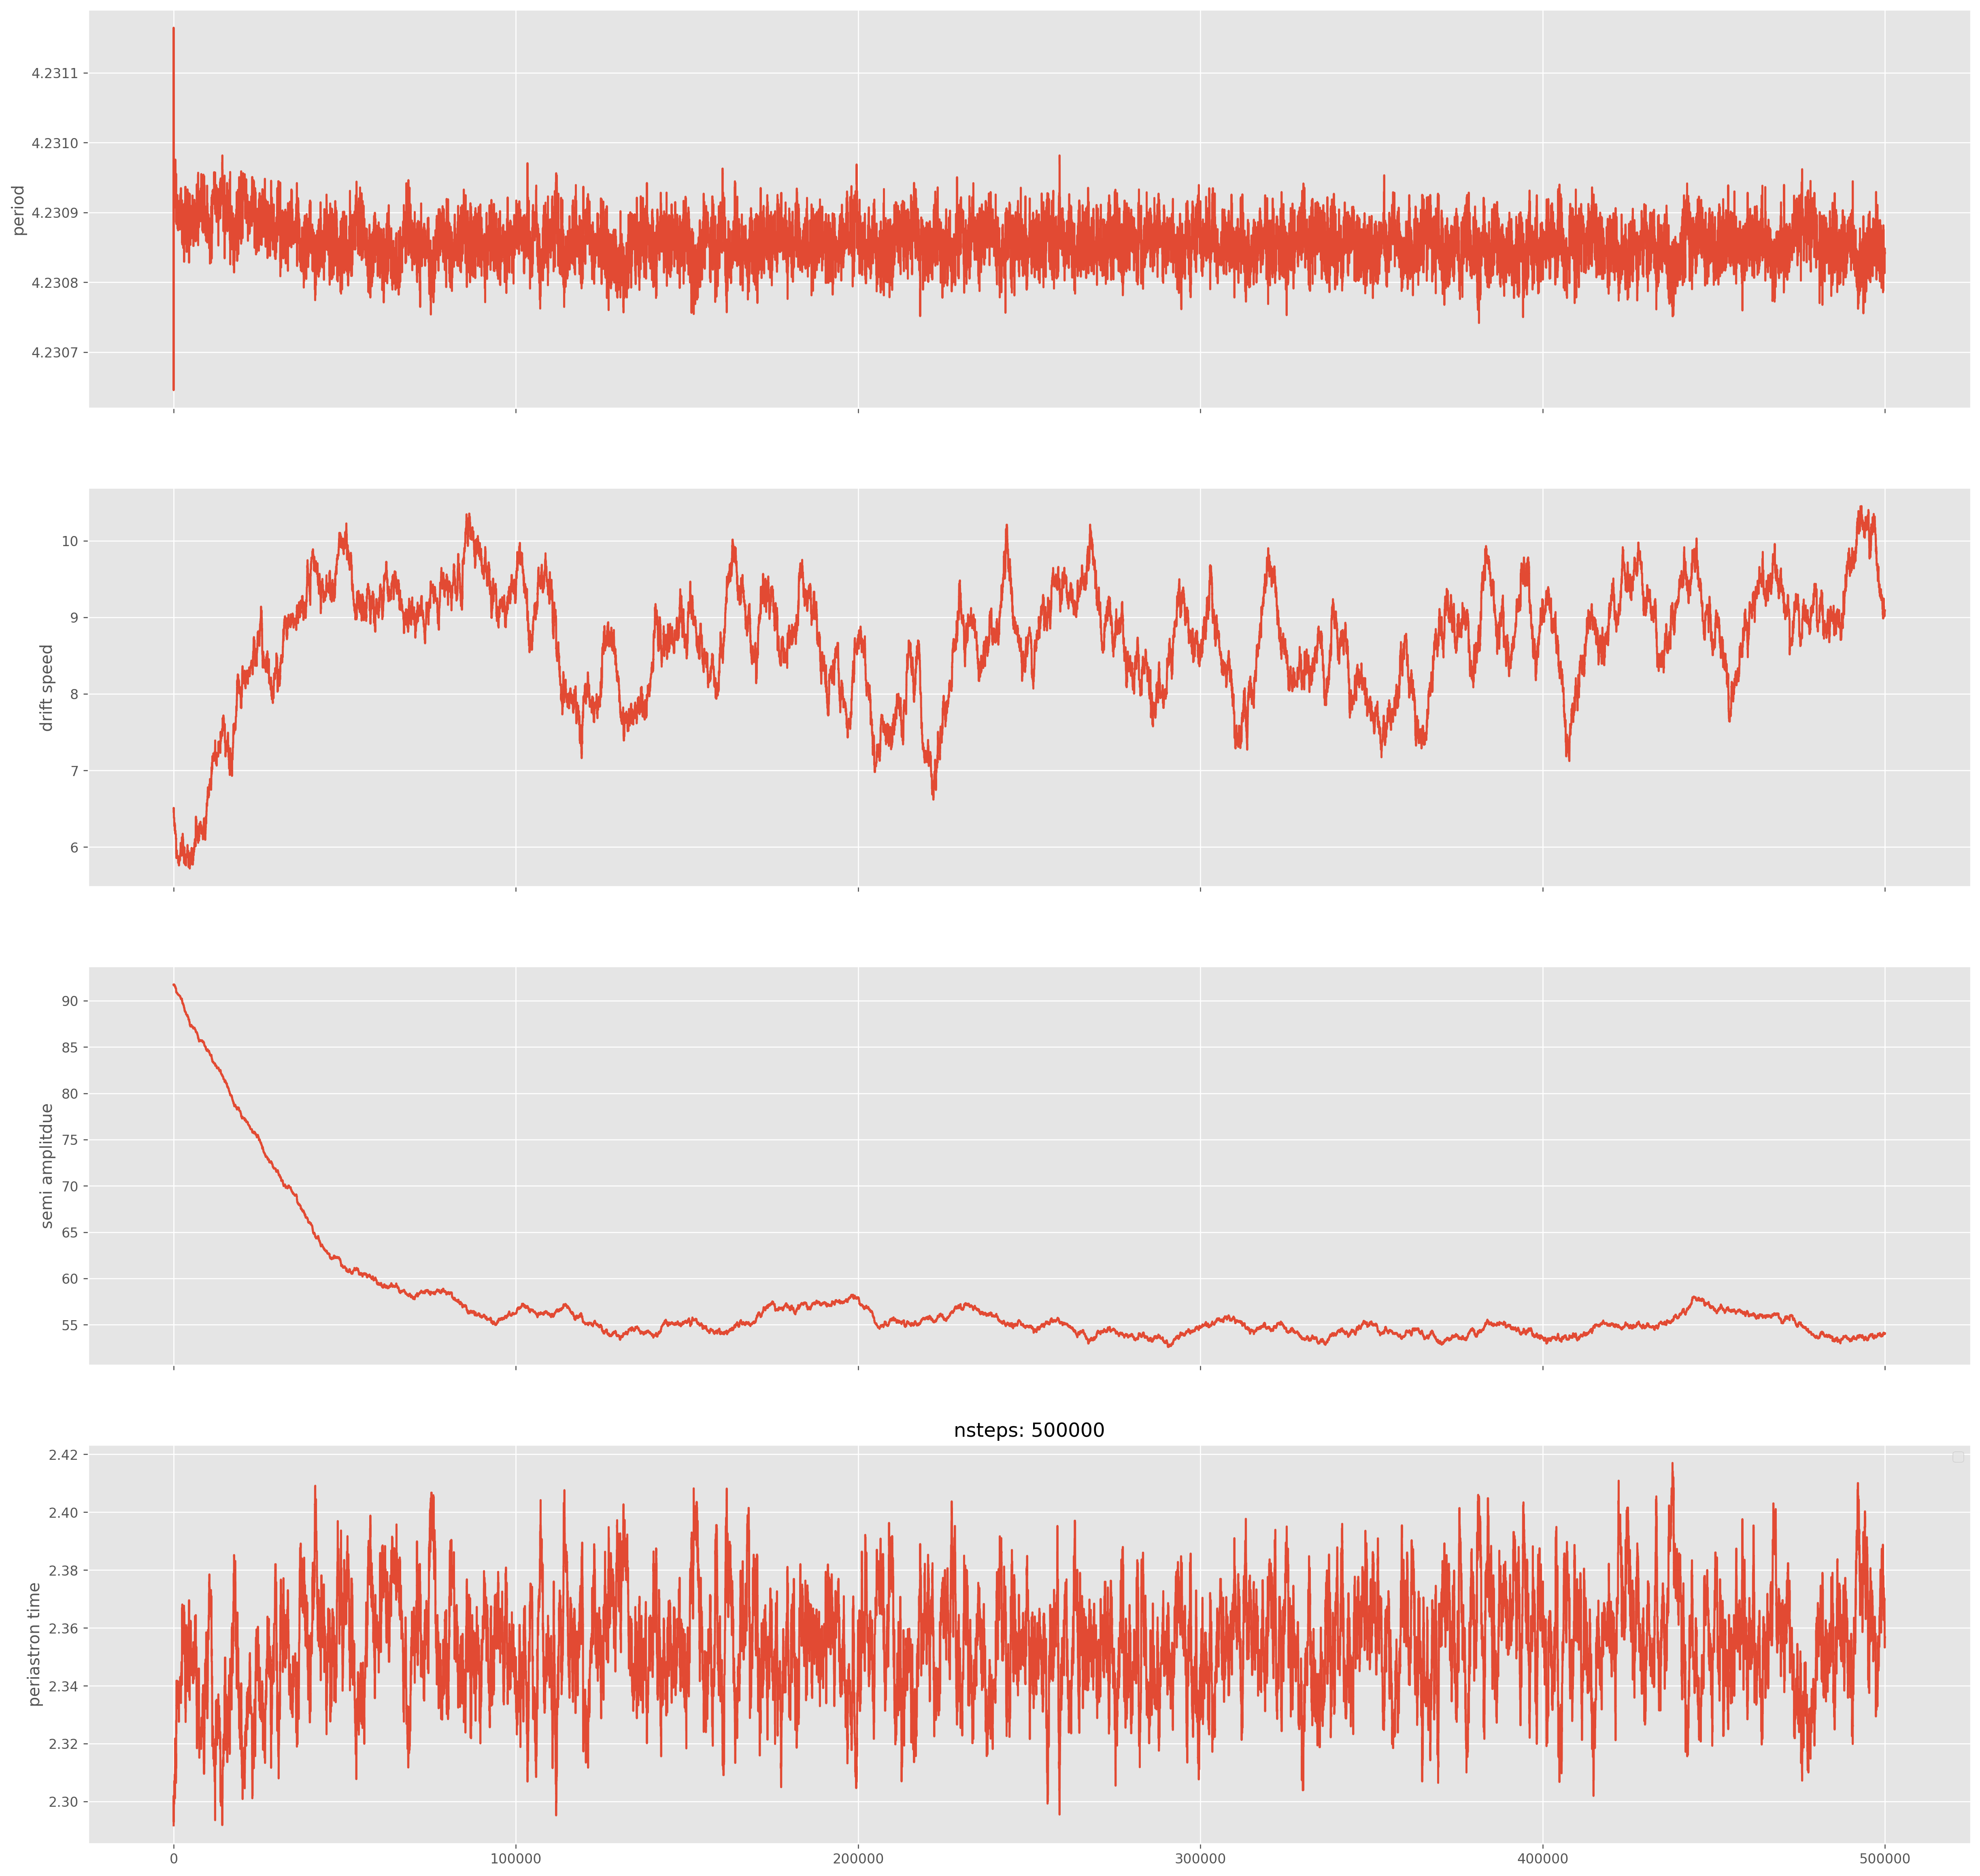

<Figure size 720x480 with 0 Axes>

In [7]:
from numpy.random import random, seed

T_p = t_p
loading = np.linspace(0,n_steps,11)
print(f'P:{Pguess},K:{K},t_p:{T_p},v_o:{v_o}')

# define chi from starting values
chi = weighted_chi2_errors(r_v,y,errors)

if eccentricity == False:
    # lists for steps taken during mcmc
    Pguesses=[Pguess]
    v_os = [v_o]
    Ks = [K]
    T_ps = [T_p]
    chis = [chi]

    for i in range(n_steps):
        if i in loading:
            print(f'{(i/n_steps)*100}%')
        v_o_step = np.random.uniform(-v_o/(RCv*v_o),v_o/(RCv*v_o))
        K_step = np.random.uniform(-K/(RCk*K),K/(K*RCk))
        T_p_step = np.random.uniform(-T_p/(T_p*RCt),T_p/(T_p*RCt))
        P_step = np.random.uniform(-Pguess/(Pguess*RCp),Pguess/(Pguess*RCp))

        new_p = P_step + Pguess
        new_v = v_o_step + v_o
        new_k = K_step + K
        new_Tp = T_p_step + T_p
        new_rv = circ_rv(new_v,new_Tp,new_k,new_p,x)

        new_chi = weighted_chi2_errors(new_rv,y,errors)

        if chi>new_chi:
            Pguess,v_o,K,T_p,chi = new_p,new_v,new_k,new_Tp,new_chi  

        else:
            a = random()
            odds = np.exp(-beta*(new_chi-chi))
            # print(f'random number: {a}, odds: {odds}')
            if a < odds:
                Pguess,v_o,K,T_p,chi = new_p,new_v,new_k,new_Tp,new_chi
                odds_counter = odds_counter + 1

        Pguesses.append(Pguess)
        v_os.append(v_o)
        Ks.append(K)
        T_ps.append(T_p)
        chis.append(chi)
        #print()
    plt.title(f"MCMC Simulation with $n = {n_steps}$ steps")
    plt.xlabel('iteration')
    plt.ylabel('$\chi^2$')
    plt.loglog(chis)
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(4,sharex=True,figsize=(25,25))
    plt.gca().set_title(f'nsteps: {n_steps}')
    axs[0].plot(Pguesses)
    axs[1].plot(v_os)
    axs[2].plot(Ks)
    axs[3].plot(T_ps)
    labels = ['period','drift speed','semi amplitdue','periastron time']
    i=0
    for ax in axs:
        ax.set(ylabel=labels[i])
        i+=1
    plt.legend()
    plt.figure()

if eccentricity == True:
    # lists for steps taken during mcmc
    Pguesses=[Pguess]
    v_os = [v_o]
    Ks = [K]
    T_ps = [T_p]
    ws = [w]
    es = [e]
    chis = [chi]

    for i in range(n_steps):
        if i in loading:
            print(f'{(i/n_steps)*10000}%')
        v_o_step = np.random.uniform(-v_o/(RCv*v_o),v_o/(RCv*v_o))
        K_step = np.random.uniform(-K/(RCk*K),K/(K*RCk))
        T_p_step = np.random.uniform(-T_p/(T_p*RCt),T_p/(T_p*RCt))
        P_step = np.random.uniform(-Pguess/(Pguess*RCp),Pguess/(Pguess*RCp))
        e_step = np.random.uniform(-e/(e*RCe),e/(e*RCe))
        w_step = np.random.uniform(-w/(w*RCw),w/(w*RCw))

        new_p = P_step + Pguess
        new_v = v_o_step + v_o
        new_k = K_step + K
        new_Tp = T_p_step + T_p
        new_e = e_step + e
        new_w = w_step + w

        if new_e < 0:
            new_e = 1/2
        if new_e >= 1:
            new_e = 1-(1/new_e)
        if new_Tp > Pguess:
            new_Tp = Pguess - (1/new_Tp)
        if new_Tp < 0:
            new_Tp = abs(new_Tp)/2

        new_rv = []
        counter = 0
        try:
            for j in x:
                M = mean_anomaly(new_p,j,new_Tp)
                E,check = newt_loop(tol,max_iter,M,new_e)
                f_a = true_anomaly(E,new_e)
                new_rv.append(ellip_rv(new_v,new_k,new_w,new_e,j,new_Tp,new_p))
                counter += 1

        except ValueError:
            print(new_p,j,new_Tp,M,E,check,f_a)

        new_chi = weighted_chi2_errors(new_rv,y,errors)

        if chi>new_chi:
            Pguess,v_o,K,T_p,chi,w,e = new_p,new_v,new_k,new_Tp,new_chi,new_w,new_e

        else:
            a = random()
            odds = np.exp(-beta*(new_chi-chi))
            # print(f'random number: {a}, odds: {odds}')
            if a < odds:
                Pguess,v_o,K,T_p,chi,w,e = new_p,new_v,new_k,new_Tp,new_chi,new_w,new_e
                odds_counter = odds_counter + 1

        Pguesses.append(Pguess)
        v_os.append(v_o)
        Ks.append(K)
        T_ps.append(T_p)
        chis.append(chi)
        ws.append(w)
        es.append(e)
        #print()


    plt.title(f"MCMC Simulation with $n = {n_steps}$ steps")
    plt.xlabel('iteration')
    plt.ylabel('$\chi^2$')
    plt.loglog(chis)
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(6,sharex=True,figsize=(25,25))
    plt.gca().set_title(f'nsteps: {n_steps}')
    axs[0].plot(Pguesses)
    axs[1].plot(v_os)
    axs[2].plot(Ks)
    axs[3].plot(T_ps)
    axs[4].plot(es)
    axs[5].plot(ws)
    labels = ['period','drift speed','semi amplitdue','periastron time','eccentricity','orbital inclination,']
    i=0
    for ax in axs:
        ax.set(ylabel=labels[i])
        i+=1
    plt.legend()
    plt.figure()

In [8]:
if eccentricity == True:
    # as a note, making the

    islice = int(n_steps/10)*2
    chiPost = chis[islice:]
    PguessPost = Pguesses[islice:]
    v_osPost = v_os[islice:]
    T_psPost = T_ps[islice:]
    ksPost = Ks[islice:]
    KsPost = Ks[islice:]
    Kspost = Ks[islice:]
    kspost = Ks[islice:]
    espost = es[islice:]
    wspost = ws[islice:]

    minarg = np.argmin(chi)

    print(f'minimum value of chi during mcmc was: {np.min(chiPost)}')
    print(f'fitting parameters were: \n',PguessPost[minarg],v_osPost[minarg],T_psPost[minarg],KsPost[minarg],espost[minarg],wspost[minarg])
    print('as: period, drift speed, periastron, semi amplitude,eccentricity,inclination')
if eccentricity == False:
    islice = int(n_steps/10)*2
    chiPost = chis[islice:]
    PguessPost = Pguesses[islice:]
    v_osPost = v_os[islice:]
    T_psPost = T_ps[islice:]
    KsPost = Ks[islice:]

    minarg = np.argmin(chi)

    print(f'minimum value of chi during mcmc was: {np.min(chiPost)}')
    print(f'fitting parameters were: \n',PguessPost[minarg],v_osPost[minarg],T_psPost[minarg],KsPost[minarg])
    print('as: period, drift speed, periastron, semi amplitude')

minimum value of chi during mcmc was: 70.13059636337582
fitting parameters were: 
 4.230858954802335 9.291689871583813 2.3499612719304293 56.19914561243623
as: period, drift speed, periastron, semi amplitude


The 95% confidence interval for each of the fitting parameters is:
P,K,Peri,chi,V
4.230900364942025
57.21878450258994
2.3852809036635354
71.64025498419977
9.696511124066811


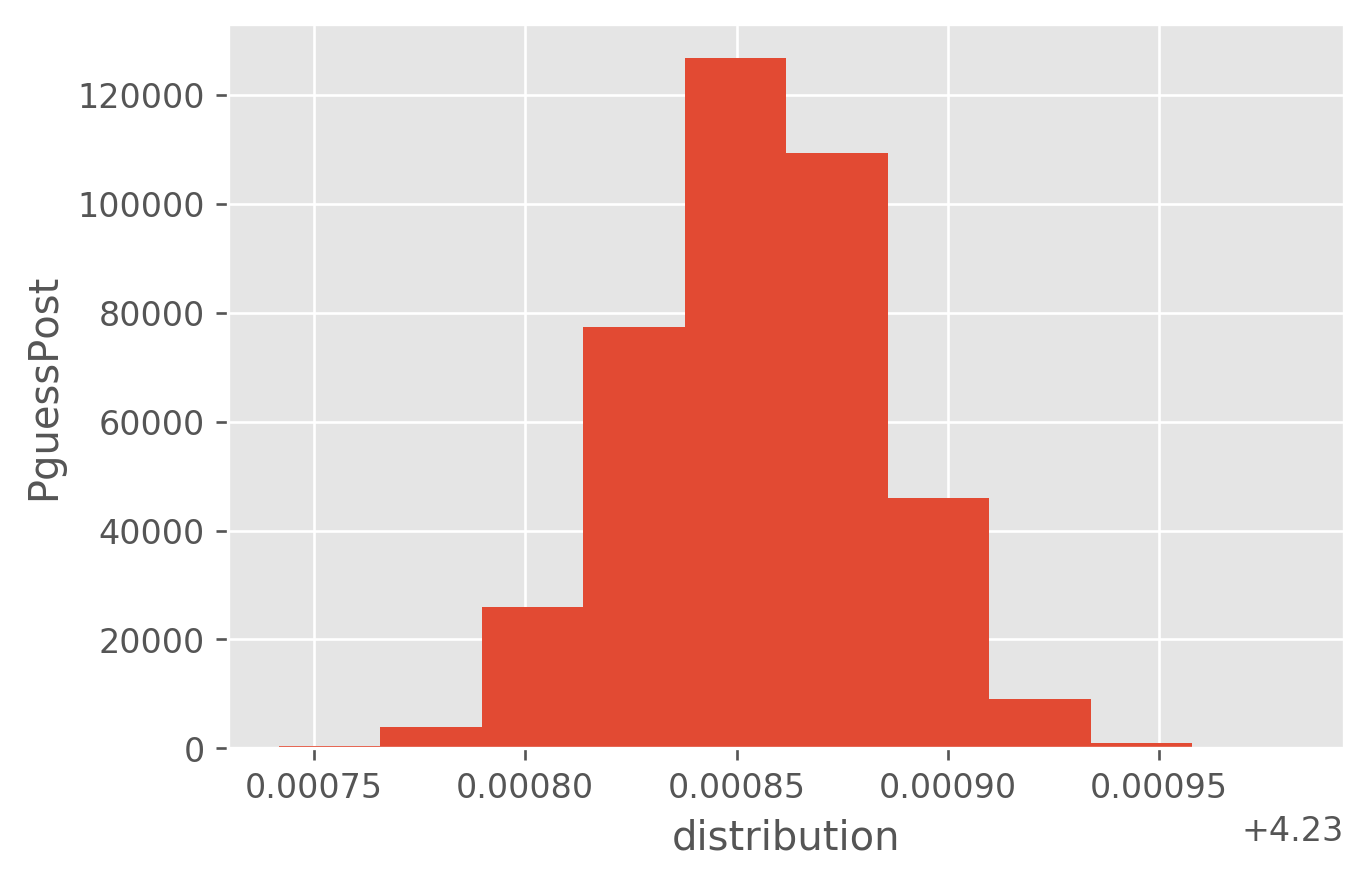

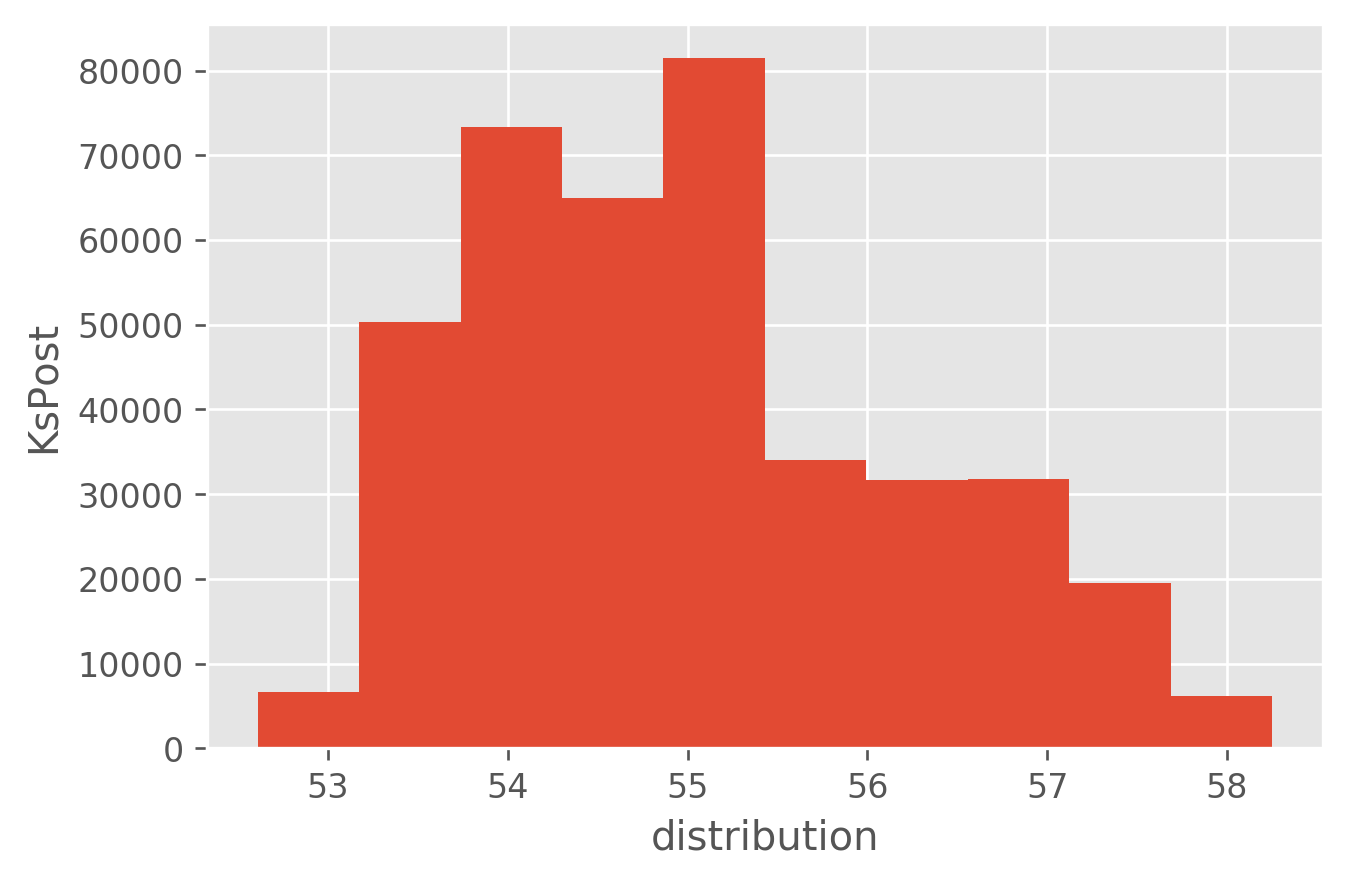

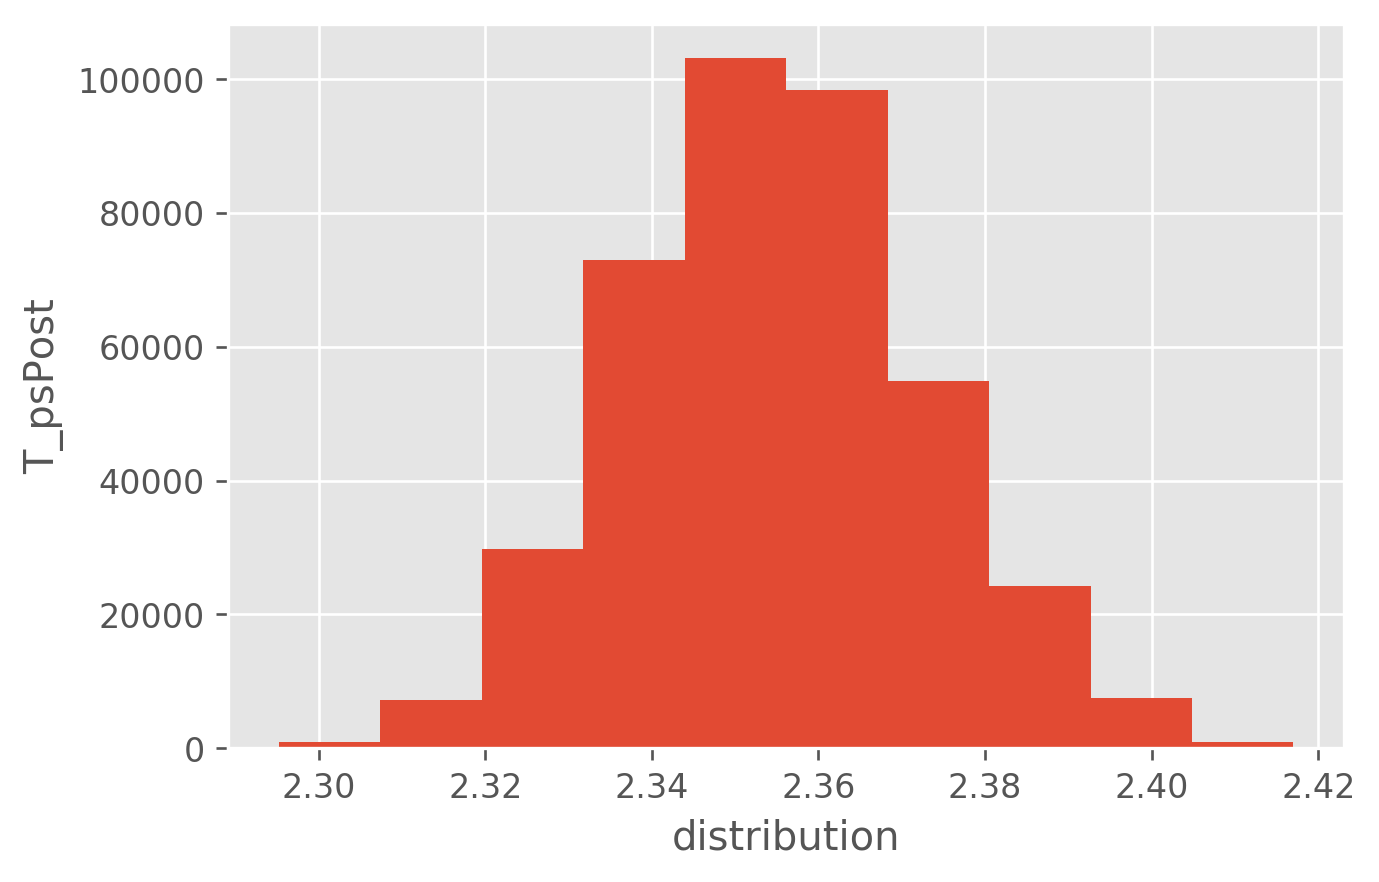

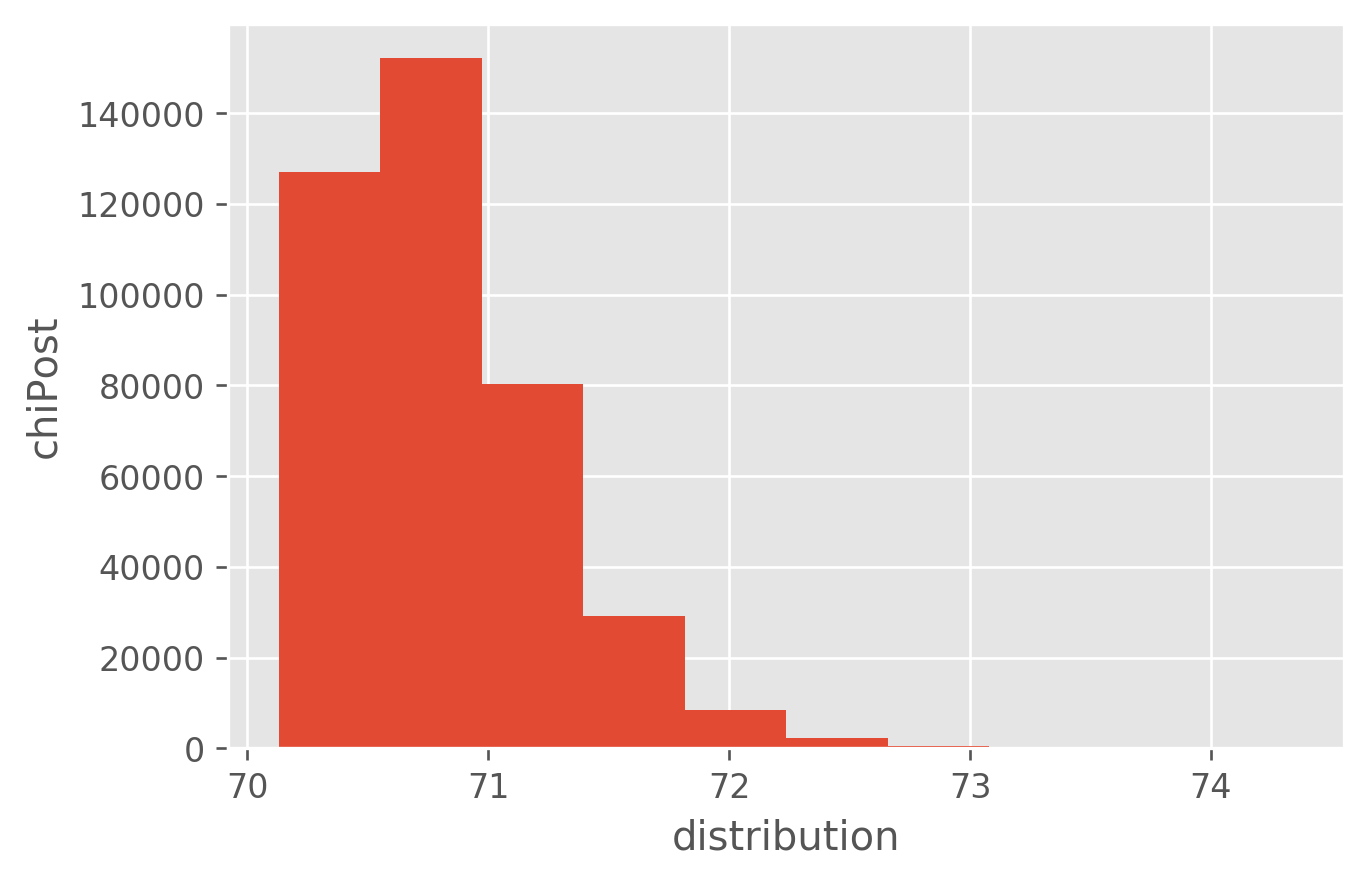

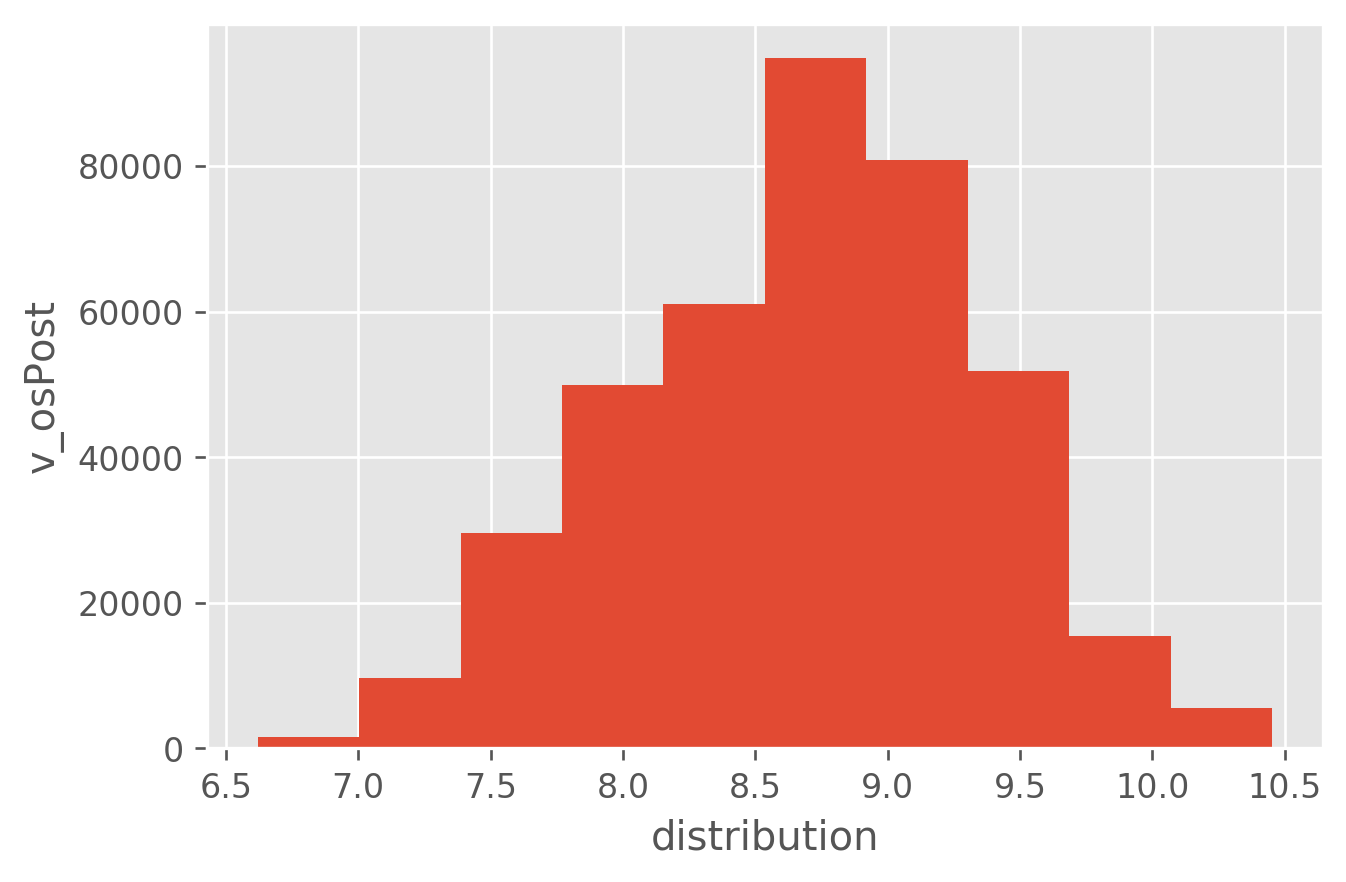

<Figure size 720x480 with 0 Axes>

In [9]:
if eccentricity == True:
    Post_list_str = ['PguessPost','KsPost','T_psPost','chiPost','v_osPost','espost','kspost','wspost']
    Post_list = [PguessPost,KsPost,T_psPost,chiPost,v_osPost,espost,Kspost,wspost]

    for i in range(len(Post_list)):
        plt.hist(Post_list[i])
        plt.xlabel("distribution")
        plt.ylabel(f"{Post_list_str[i]}")
        plt.figure()

    print("The 95% confidence interval for each of the fitting parameters is:")
    print('P,K,Peri,chi,V')
    for i in Post_list:
        print(f'{np.quantile(i,0.95)}')

if eccentricity == False:
    Post_list_str = ['PguessPost','KsPost','T_psPost','chiPost','v_osPost']
    Post_list = [PguessPost,KsPost,T_psPost,chiPost,v_osPost]

    for i in range(len(Post_list)):
        plt.hist(Post_list[i])
        plt.xlabel("distribution")
        plt.ylabel(f"{Post_list_str[i]}")
        plt.figure()

    print("The 95% confidence interval for each of the fitting parameters is:")
    print('P,K,Peri,chi,V')
    for i in Post_list:
        print(f'{np.quantile(i,0.95)}')

In [10]:
'''if eccentricity == False: 
    Post_list2 = [KsPost,T_psPost,v_osPost,PguessPost]
    Post_list2_str = ['KsPost','T_psPost','v_osPost','PguessPost']
    for j in range(len(Post_list2)):
        print(f'x = {Post_list_str[j]}')
        for i in range(len(Post_list2)):
            print(f'y = {Post_list2_str[i]}')
            imin = np.argmin(chiPost)
            imax = np.argmax(chiPost)
            plt.scatter(Post_list2[j],Post_list2[i],s=.5,
                        c=chiPost,
                        vmin=chiPost[imin],
                        vmax=chiPost[imax])
            plt.colorbar(label='$\chi^2$')
            plt.title(f'{Post_list2_str[j]} vs {Post_list2_str[i]}')
            plt.xlim(min(Post_list2[j]),max(Post_list2[j]))
            plt.ylim(min(Post_list2[i]),max(Post_list2[i]))
            plt.grid(linestyle='-',linewidth='0.1')
            plt.figure()
if eccentricity == True:
    Post_list2 = [KsPost,T_psPost,v_osPost,PguessPost,espost,wspost]
    Post_list2_str = ['KsPost','T_psPost','v_osPost','PguessPost','espost','wspost']
    for j in range(len(Post_list2)):
        print(f'x = {Post_list_str[j]}')
        for i in range(len(Post_list2)):
            print(f'y = {Post_list2_str[i]}')
            imin = np.argmin(chiPost)
            imax = np.argmax(chiPost)
            plt.scatter(Post_list2[j],Post_list2[i],s=.5,
                        c=chiPost,
                        vmin=chiPost[imin],
                        vmax=chiPost[imax])
            plt.colorbar(label='$\chi^2$')
            plt.title(f'{Post_list2_str[j]} vs {Post_list2_str[i]}')
            plt.xlim(min(Post_list2[j]),max(Post_list2[j]))
            plt.ylim(min(Post_list2[i]),max(Post_list2[i]))
            plt.grid(linestyle='-',linewidth='0.1')
            plt.figure()'''

"if eccentricity == False: \n    Post_list2 = [KsPost,T_psPost,v_osPost,PguessPost]\n    Post_list2_str = ['KsPost','T_psPost','v_osPost','PguessPost']\n    for j in range(len(Post_list2)):\n        print(f'x = {Post_list_str[j]}')\n        for i in range(len(Post_list2)):\n            print(f'y = {Post_list2_str[i]}')\n            imin = np.argmin(chiPost)\n            imax = np.argmax(chiPost)\n            plt.scatter(Post_list2[j],Post_list2[i],s=.5,\n                        c=chiPost,\n                        vmin=chiPost[imin],\n                        vmax=chiPost[imax])\n            plt.colorbar(label='$\\chi^2$')\n            plt.title(f'{Post_list2_str[j]} vs {Post_list2_str[i]}')\n            plt.xlim(min(Post_list2[j]),max(Post_list2[j]))\n            plt.ylim(min(Post_list2[i]),max(Post_list2[i]))\n            plt.grid(linestyle='-',linewidth='0.1')\n            plt.figure()\nif eccentricity == True:\n    Post_list2 = [KsPost,T_psPost,v_osPost,PguessPost,espost,wspost]\n   

70.13059636337582


<Figure size 720x480 with 0 Axes>

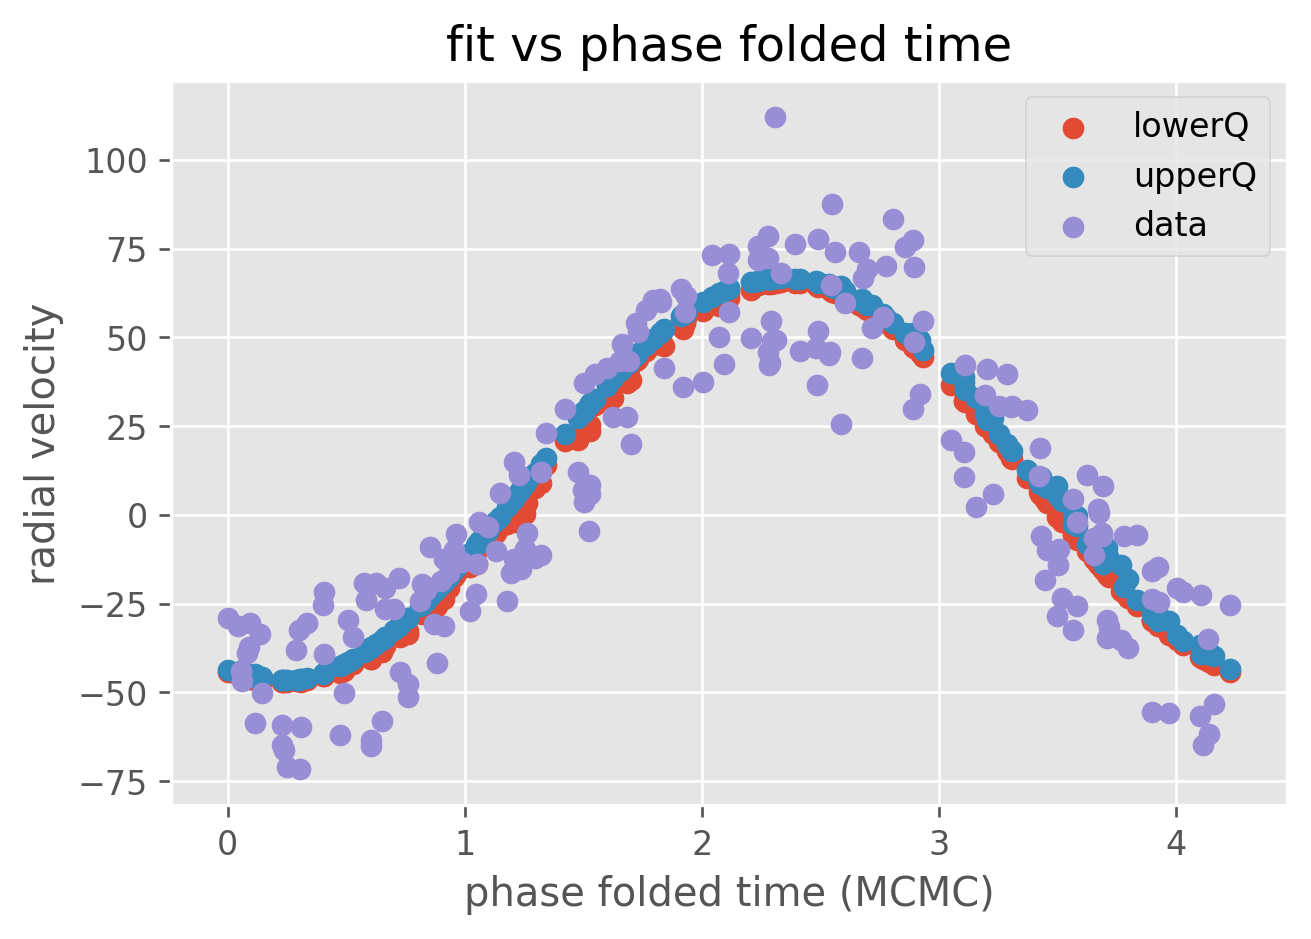

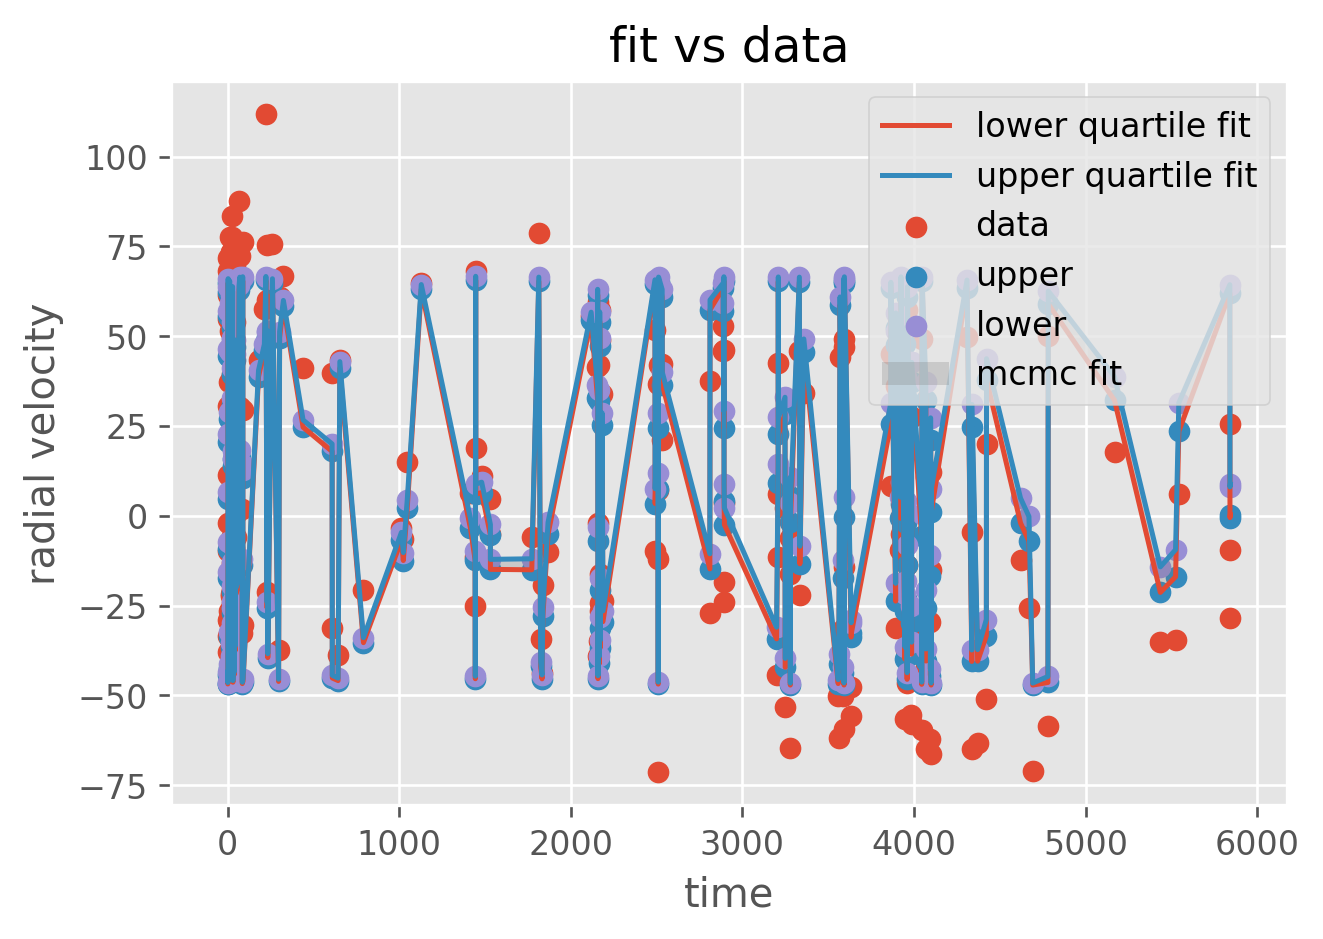

<Figure size 720x480 with 0 Axes>

In [11]:
chi_min = np.argmin(chiPost)
print(chiPost[chi_min])
Vaccurate = v_osPost[chi_min]
Kaccurate = KsPost[chi_min]
Paccurate = PguessPost[chi_min]
Taccurate = T_psPost[chi_min]
if eccentricity == True:
    Eaccurate = espost[chi_min]
    Waccurate = wspost[chi_min]

tfolded = x%Paccurate

models = []
if eccentricity == True:
    for i in range(n_curves):
        v_o,K,w,e,t_p,Pguess = v_osPost[i*spacing],KsPost[i*spacing],wspost[i*spacing],espost[i*spacing],T_psPost[i*spacing],PguessPost[i*spacing]
        r_v = []
        for j in x:
            M = mean_anomaly(Pguess,j,t_p)
            i = 0
            xi = M
            yy = abs(f(xi,e,M))
            while yy > tol and i < max_iter:
                xi = newt_step(xi,e,M)
                yy = abs(f(xi,e,M))
                i += 1
            E = xi
            f_a = true_anomaly(E,e)
            r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))
        models.append(r_v)

if eccentricity == False:
    models = np.array([circ_rv(v_osPost[i*spacing], T_psPost[i*spacing], KsPost[i*spacing], PguessPost[i*spacing],x)
                   for i in range(n_curves)])

model_lowerq = np.quantile(models, 0.025, axis=0)
model_upperq = np.quantile(models, 0.975, axis=0)
model_avg    = np.quantile(models,0.5,axis=0)

plt.scatter(tfolded,model_lowerq,label='lowerQ')
plt.scatter(tfolded,model_upperq,label='upperQ')
plt.scatter(tfolded,y,label='data')
plt.title('fit vs phase folded time')
plt.xlabel('phase folded time (MCMC)')
plt.ylabel('radial velocity')
plt.legend()
plt.figure()

plt.scatter(x,y,label='data')
plt.scatter(x,model_lowerq,label='upper')
plt.scatter(x,model_upperq,label='lower')
plt.plot(x,model_lowerq,label='lower quartile fit')
plt.fill_between(x,model_lowerq,model_upperq,label='mcmc fit',alpha=0.25)
plt.plot(x,model_upperq,label='upper quartile fit')
plt.title('fit vs data')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.legend()
plt.figure()

best chi squared: 70.13059636337582
best drift speed: 8.841182148934392
best periastron time: 2.3539288417268733
best velocity semi amplitude: 55.25862450440955
best period: 4.230857834916635
semi major in AU hopefully: 0.051872925409015516
msine factor: 8.386816306277665e+26
6.524042130918982e-14


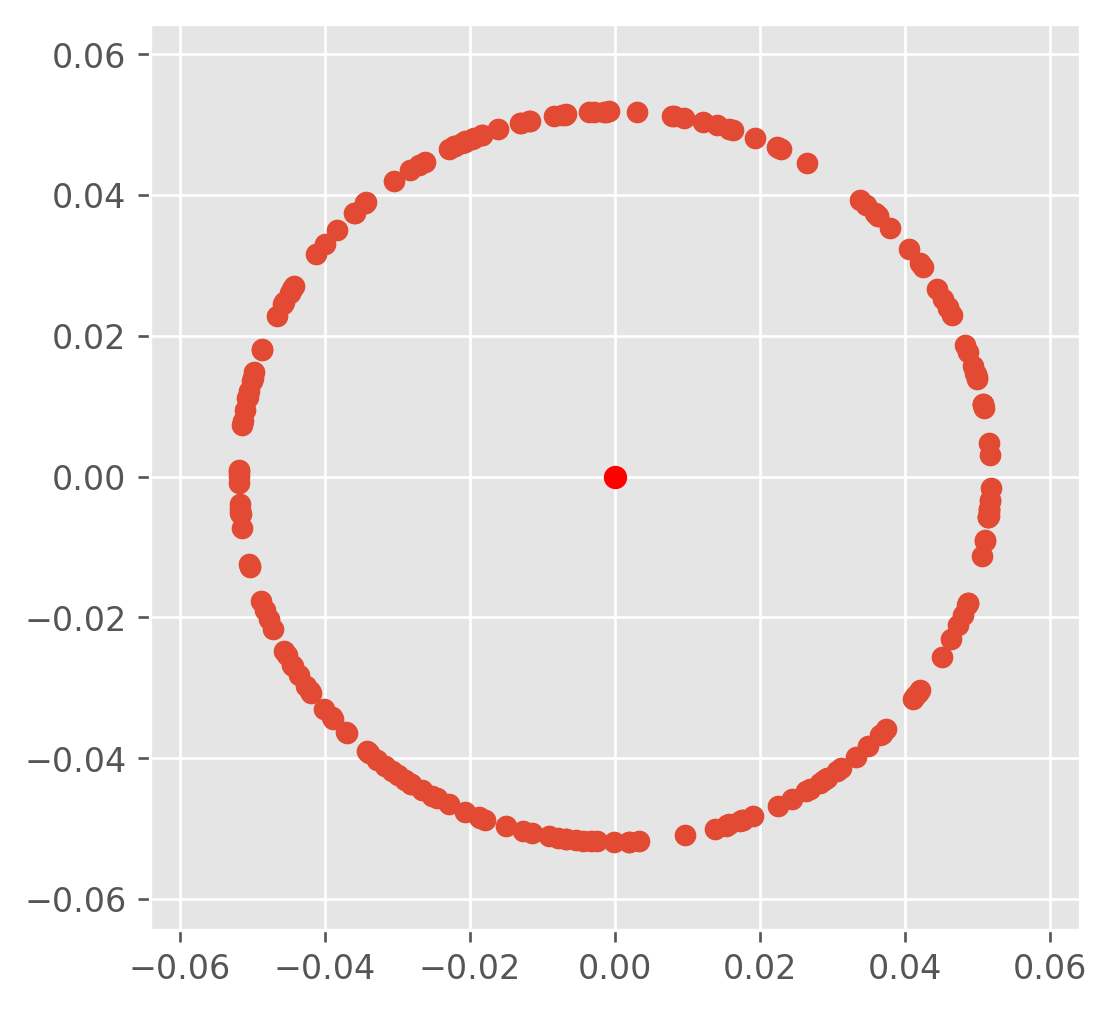

In [12]:
# v_o average drift speed
# t is time in days,
# T_p is the time when the orbit goes through periastron,
# K is the velocity semi-amplitude of the orbital motion in metres per second, and
# P is the orbital period of the orbit in days
plt.style.use('ggplot')
print(f'best chi squared: {chiPost[chi_min]}')
print(f'best drift speed: {Vaccurate}')
print(f'best periastron time: {Taccurate}')
print(f'best velocity semi amplitude: {Kaccurate}')
print(f'best period: {Paccurate}')
if eccentricity == True:
    print(f'best eccentricity: {Eaccurate}')
    print(f'best orbital inclination angle: {Waccurate}')

# FIX ME THEN SAVE ME TO DATAFILE
# fix / experiment with residual lomb scargle
# MAKE PLottiNG IN 1  FUNCTION
# ANALYZE RESIDUAL DATA

def semimajor(stellar_mass, p):
    G = 6.67430e-11 # gravitational constant in m^3/kg/s^2
    M_sun = 1.989*10**30 # mass of the sun in kg**
    AU = 149597870700 # astronomical unit in meters

    # Convert star_mass from solar masses to kg

    star_mass_kg = stellar_mass * M_sun

    # Convert period from days to seconds
    period_s = p * 24 * 3600
    # Calculate the semimajor axis using Kepler's third law
    a = ((G * star_mass_kg * period_s**2)/(4 * math.pi**2))**(1/3)

    # Convert semimajor axis from meters to astronomical units
    a_au = a / AU

    return a_au

a = semimajor(m_star,Paccurate)

print(f'semi major in AU hopefully: {a}')
import numpy as np

def minimum_mass(P, K, e, M_star):
    """
    Calculate M_psin(i) of the secondary object in a binary system.

    Parameters:
    P (float): Orbital period of the system in days.
    K (float): Radial velocity semi-amplitude in m/s.
    e (float): Orbital eccentricity (0 <= e < 1).
    M_star (float): Mass of the primary star in solar masses.

    Returns:
    float: Minimum mass (M_p * sin(i)) of the secondary object in Jupiter masses.
    """

    # Constants
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.989e30  # Solar mass in kg
    M_jup = 1.898e27  # Jupiter mass in kg
    day_to_sec = 86400  # Number of seconds in a day

    # Convert period to seconds
    P = P * day_to_sec

    # Convert primary star mass to kg
    M_star_kg = M_star * M_sun

    # Calculate the mass function
    mass_function = (P * K**3) / (2 * np.pi * G * (1 - e**2)**1.5)

    # Calculate the minimum mass (M_p * sin(i)) in Jupiter masses
    M_psin_i = (mass_function / M_star_kg**2) * M_jup

    return M_psin_i


def msine(k,p,stellar_mass,e):
    m_sun = 1.989*10**30
    msine = K * (1/((2*np.pi*G)/p)**(1/3)) * (1-e**2)**(1/2) * (stellar_mass*m_sun)**(2/3)
    return msine

if eccentricity == False:
    print(f'msine factor: {msine(Kaccurate,Paccurate*86400,m_star,0)}')
    print(minimum_mass(Paccurate,Kaccurate,0,m_star))
    post_mcmc = chiPost[chi_min],Paccurate,Vaccurate,Taccurate,Kaccurate
    
if eccentricity == True:
    print(f'msine factor: {msine(Kaccurate,Paccurate*86400,m_star,Eaccurate)}')
    post_mcmc = chiPost[chi_min],Paccurate,Vaccurate,Taccurate,Kaccurate,Eaccurate,Waccurate


from matplotlib import pyplot as plt
import math
import numpy as np

def radial(a, e, f):
    # Calculate the radial distance
    r = a*(1 - e**2)/(1 + e*math.cos(f))
    return r

def cartesian(r,f):
    # Calculate the cartesian coordinates
    x = r*math.cos(f)
    y = r*math.sin(f)
    return x, y


xlist = []
ylist = []

if eccentricity == False:
    Eaccurate = 0

for j in x:
    M = mean_anomaly(Paccurate,j,Taccurate)
    i = 0
    xi = M
    yy = abs(f(xi,Eaccurate,M))
    while yy > tol and i < max_iter:
        xi = newt_step(xi,Eaccurate,M)
        yy = abs(f(xi,Eaccurate,M))
        i += 1
    E = xi
    f_a = true_anomaly(E,Eaccurate)
    r = radial(a,Eaccurate,f_a)
    xcoord,ycoord = cartesian(r,f_a)
    xlist.append(xcoord)
    ylist.append(ycoord)

plt.rcParams['figure.figsize'] = (5,5)
#xlist,ylist,rlist = eccorbit(Paccurate,x[-1],x[-1]*10,0.7,m,Taccurate)
plt.scatter(xlist,ylist)
plt.plot(0,0,'ro',label='origin')
plt.show()
#aw yea

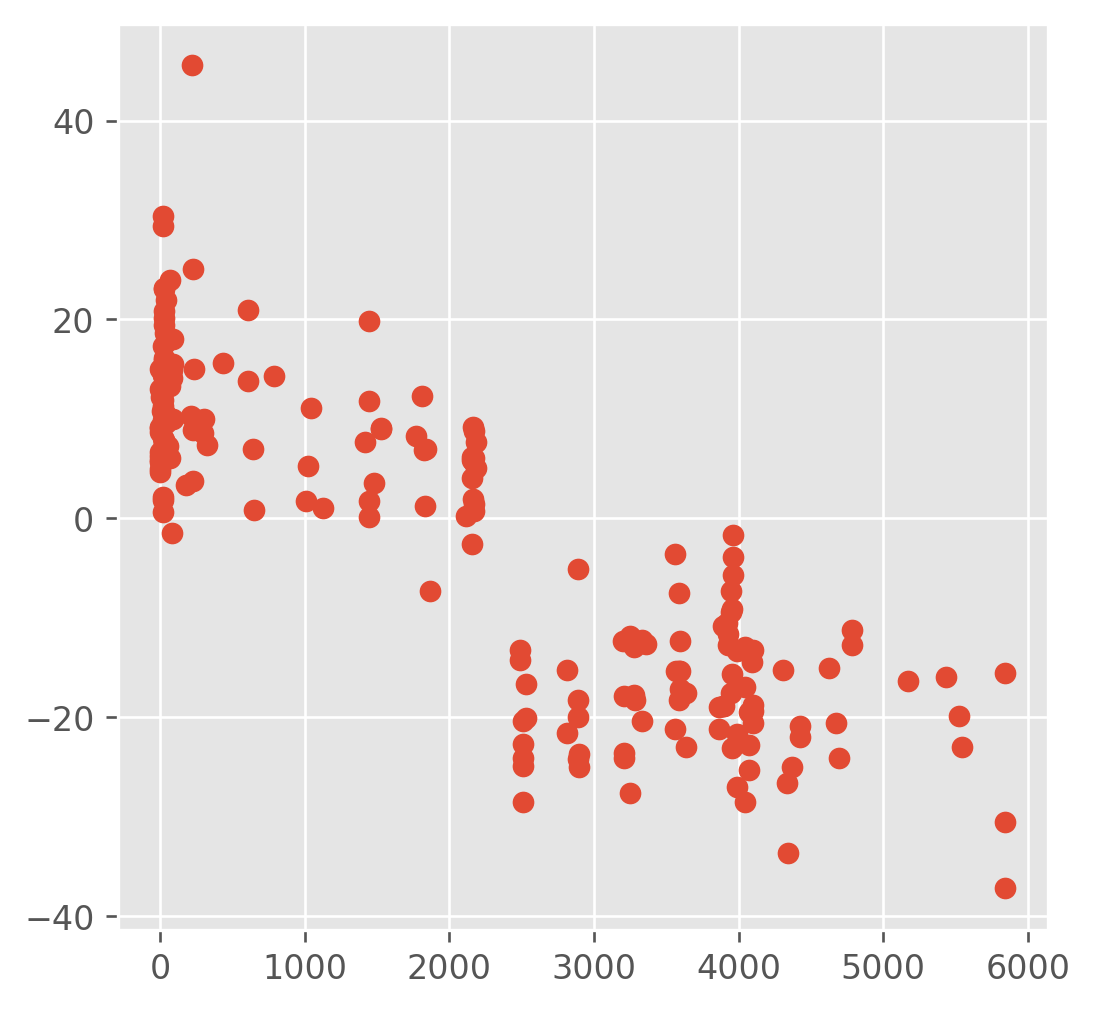

In [13]:
y_res = y - model_avg
plt.scatter(x,y_res)

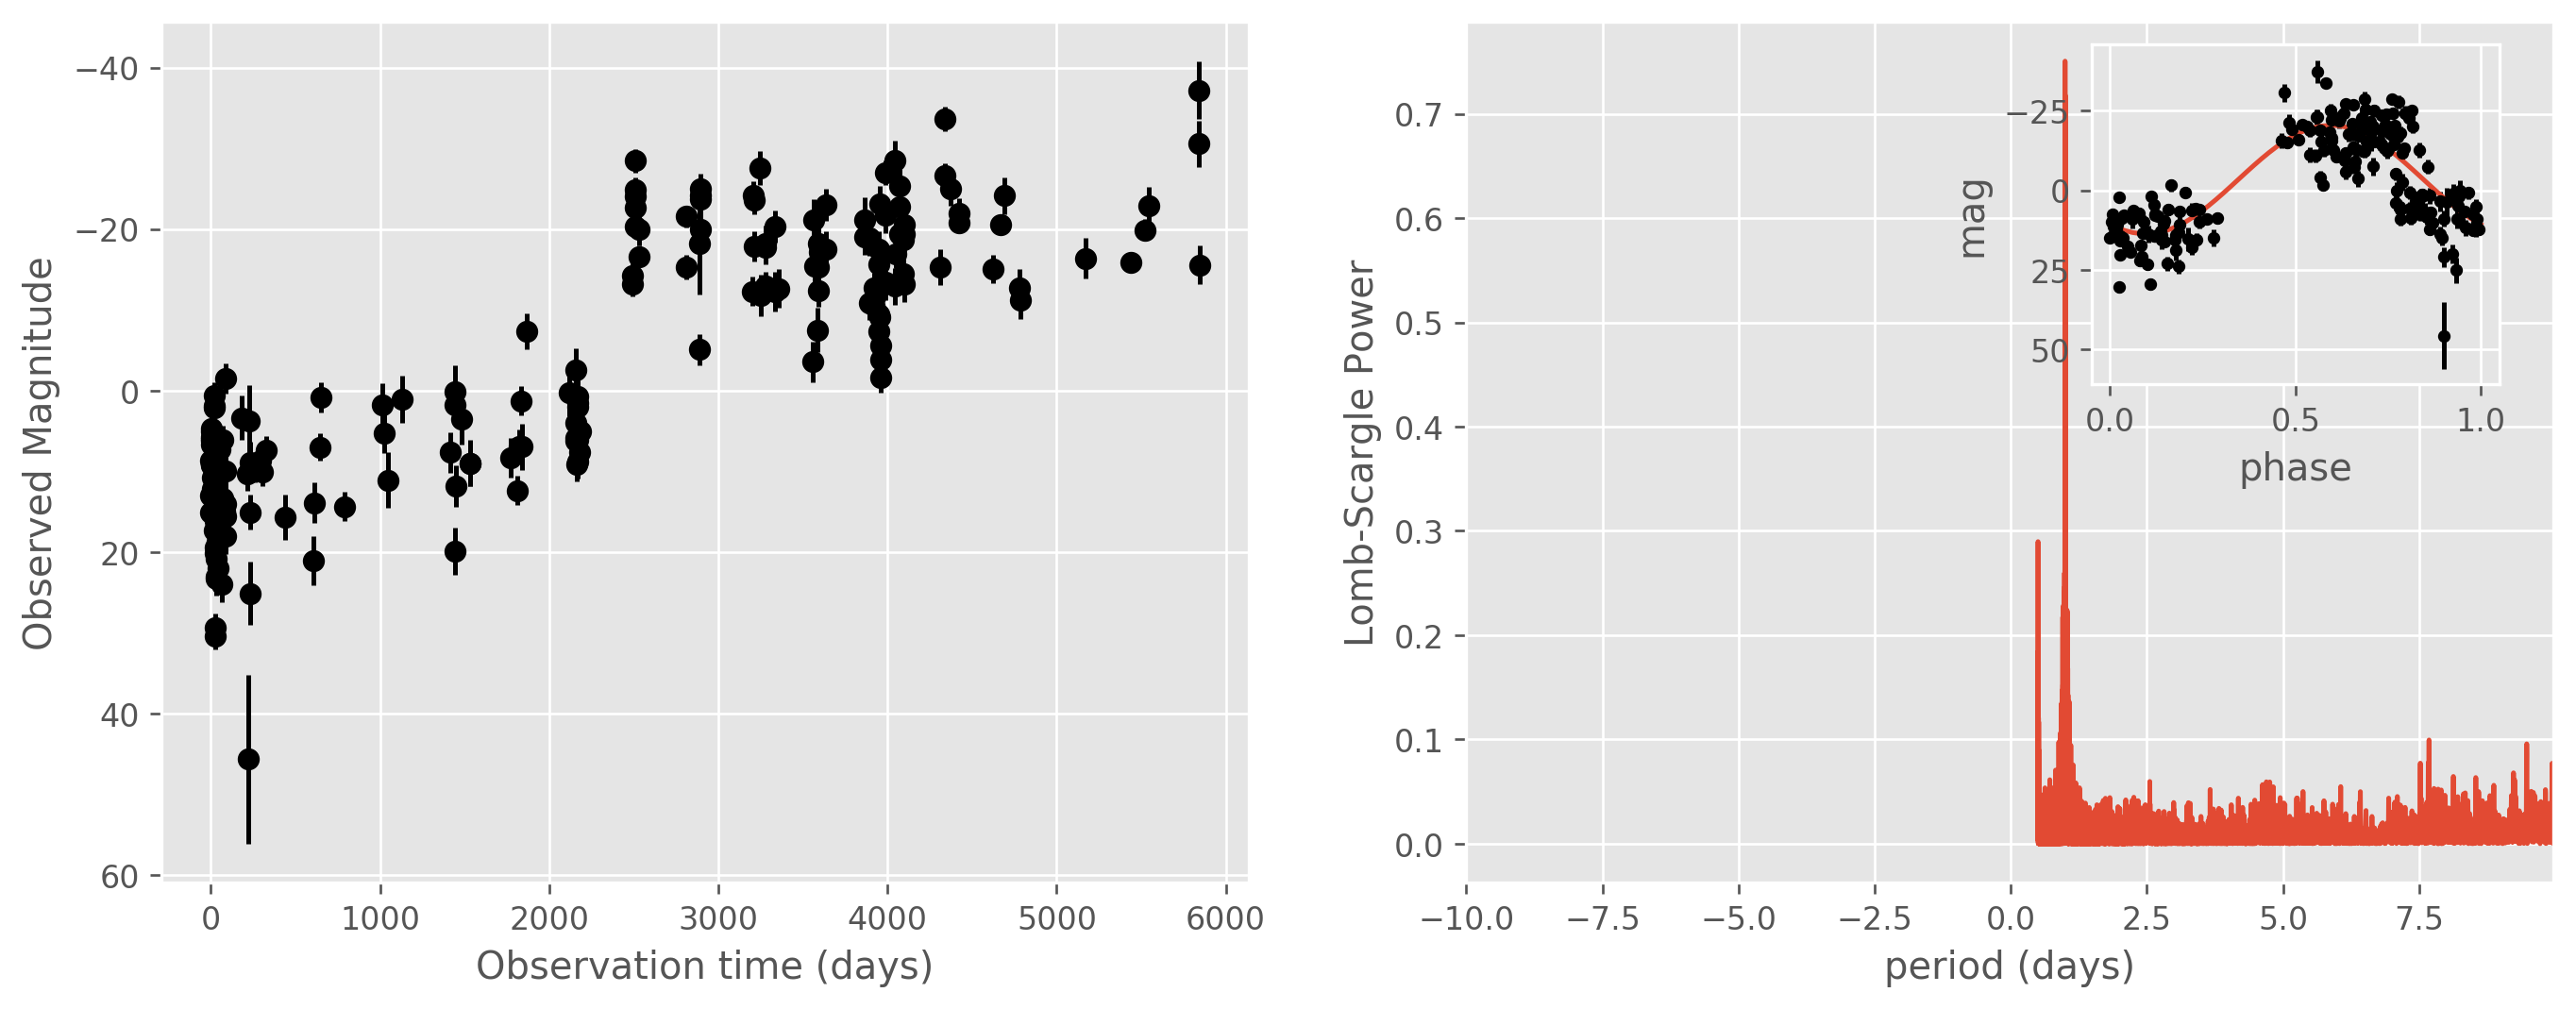

Suggested period: 0.99737 days


In [14]:
import math
y = y_res
from astropy.timeseries import LombScargle

    
# generate data and compute the periodogram
freq, PLS = LombScargle(x, y, errors).autopower(minimum_frequency=1 / 4000,
                                               maximum_frequency=1 / 0.5)
best_freq = freq[np.argmax(PLS)]
phase = (x * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1)
mag_fit = LombScargle(x, y, errors).model(t=phase_fit / best_freq,
                                          frequency=best_freq)

# set up the figure & axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
inset = fig.add_axes([0.78, 0.56, 0.15, 0.3])

# plot the raw data
ax[0].errorbar(x, y, errors, fmt='ok', elinewidth=1.5, capsize=0)
ax[0].invert_yaxis()
ax[0].set(
          xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

# plot the periodogram
ax[1].plot(1. / freq, PLS)
ax[1].set(xlim=(-10,1/best_freq*10),
          xlabel='period (days)',
          ylabel='Lomb-Scargle Power',)

# plot the phased data & model in the inset
inset.errorbar(phase, y, errors, fmt='.k', capsize=0)
inset.plot(phase_fit, mag_fit)
inset.invert_yaxis()
inset.set_xlabel('phase')
inset.set_ylabel('mag')
plt.show()
print(f'Suggested period: {1/best_freq:.5f} days')
Pguess = 1 / best_freq
#Pguess = 500


In [15]:
import numpy as np
from astropy.stats import LombScargle

def check_residual_periodicity(time, residuals, frequency):
    """
    Check if the given frequency is a significant periodicity in the residuals using a Lomb-Scargle periodogram.
    
    Parameters
    ----------
    time : array-like
        Array of times corresponding to the residuals.
    residuals : array-like
        Array of residuals to be checked for periodicity.
    frequency : float
        Frequency to be checked for significant periodicity.
    
    Returns
    -------
    bool
        True if the given frequency is a significant periodicity, False otherwise.
    """
    
    # Compute the Lomb-Scargle periodogram of the residuals
    frequency, power = LombScargle(time, residuals).autopower()
    
    # Check if the given frequency is a significant peak in the periodogram
    threshold = 0.95  # Set a threshold for peak significance
    power_threshold = np.percentile(power, threshold * 100)
    is_significant = power[np.argmin(np.abs(frequency - frequency))] > power_threshold
    
    return is_significant
print(check_residual_periodicity(x,y,1/Pguess))

True


(129.8952488645819, 0.9973729005341727, -2.0184060799550774, 0.04155720418892386, 41.39842612640015)


Current chi: 129.8952488645819


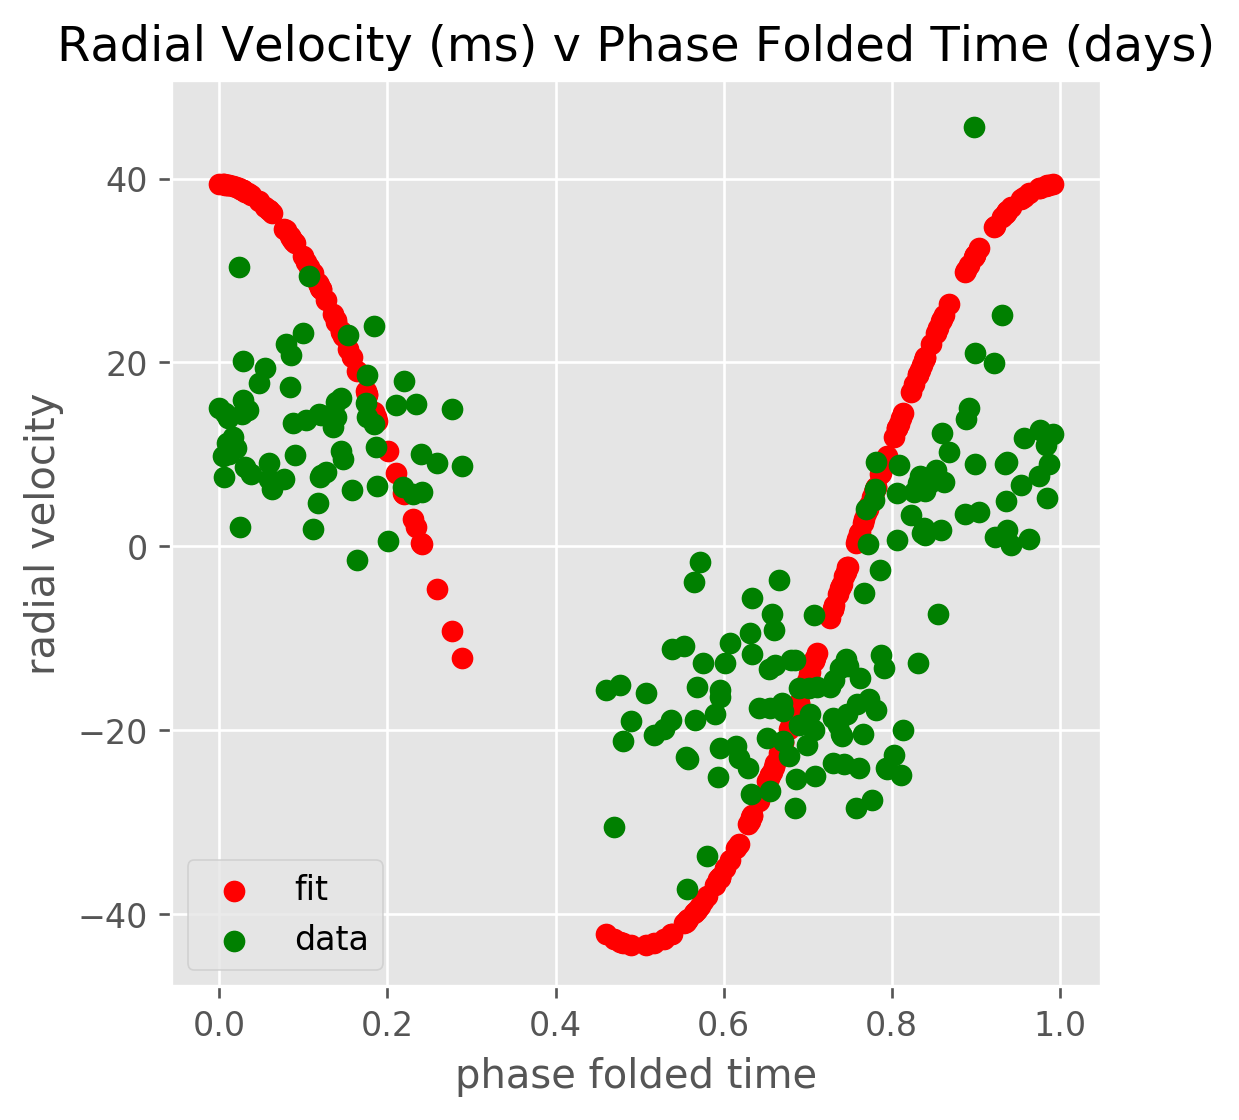

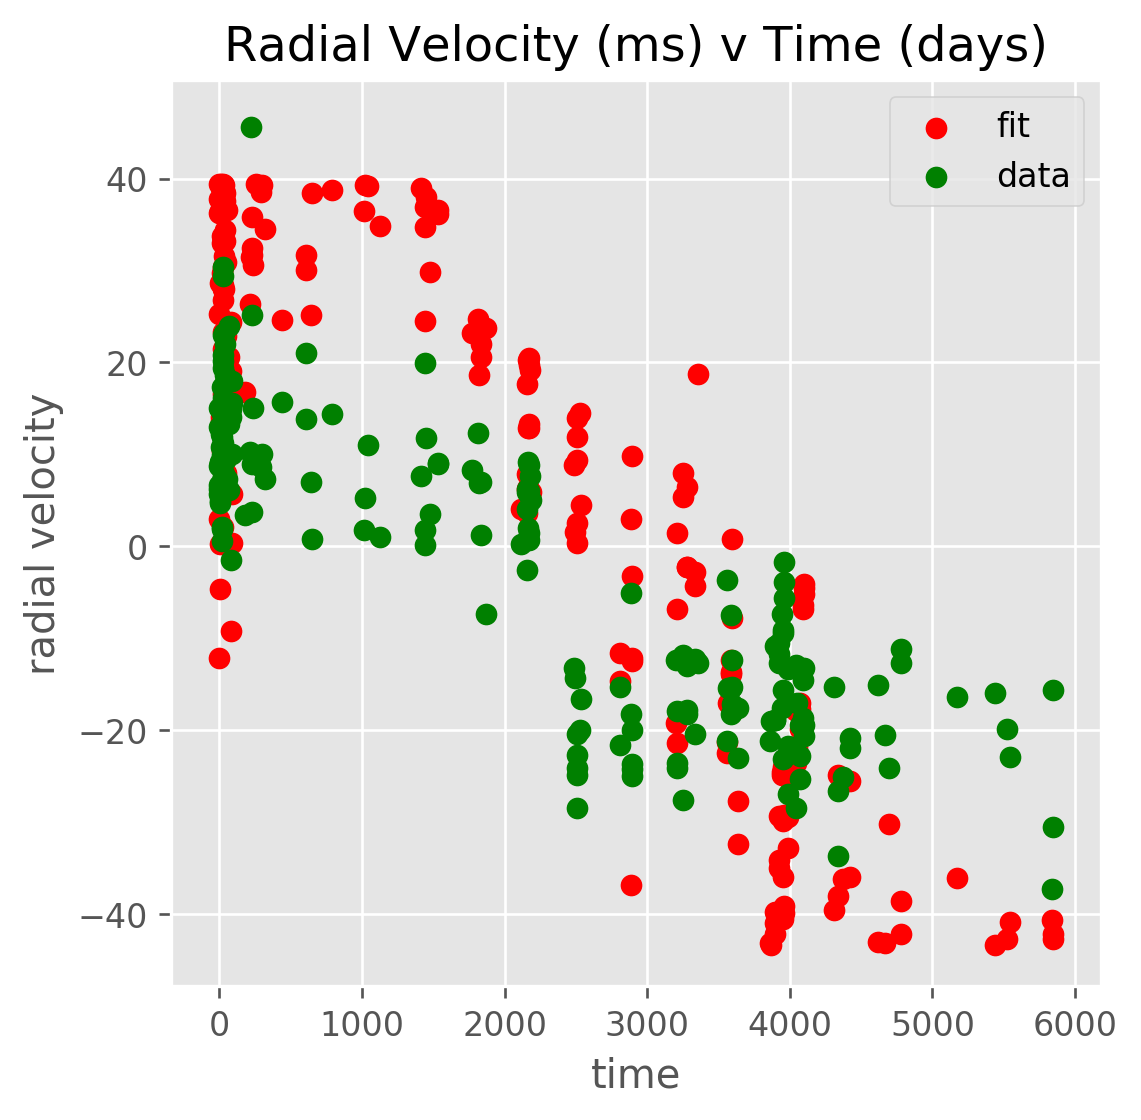

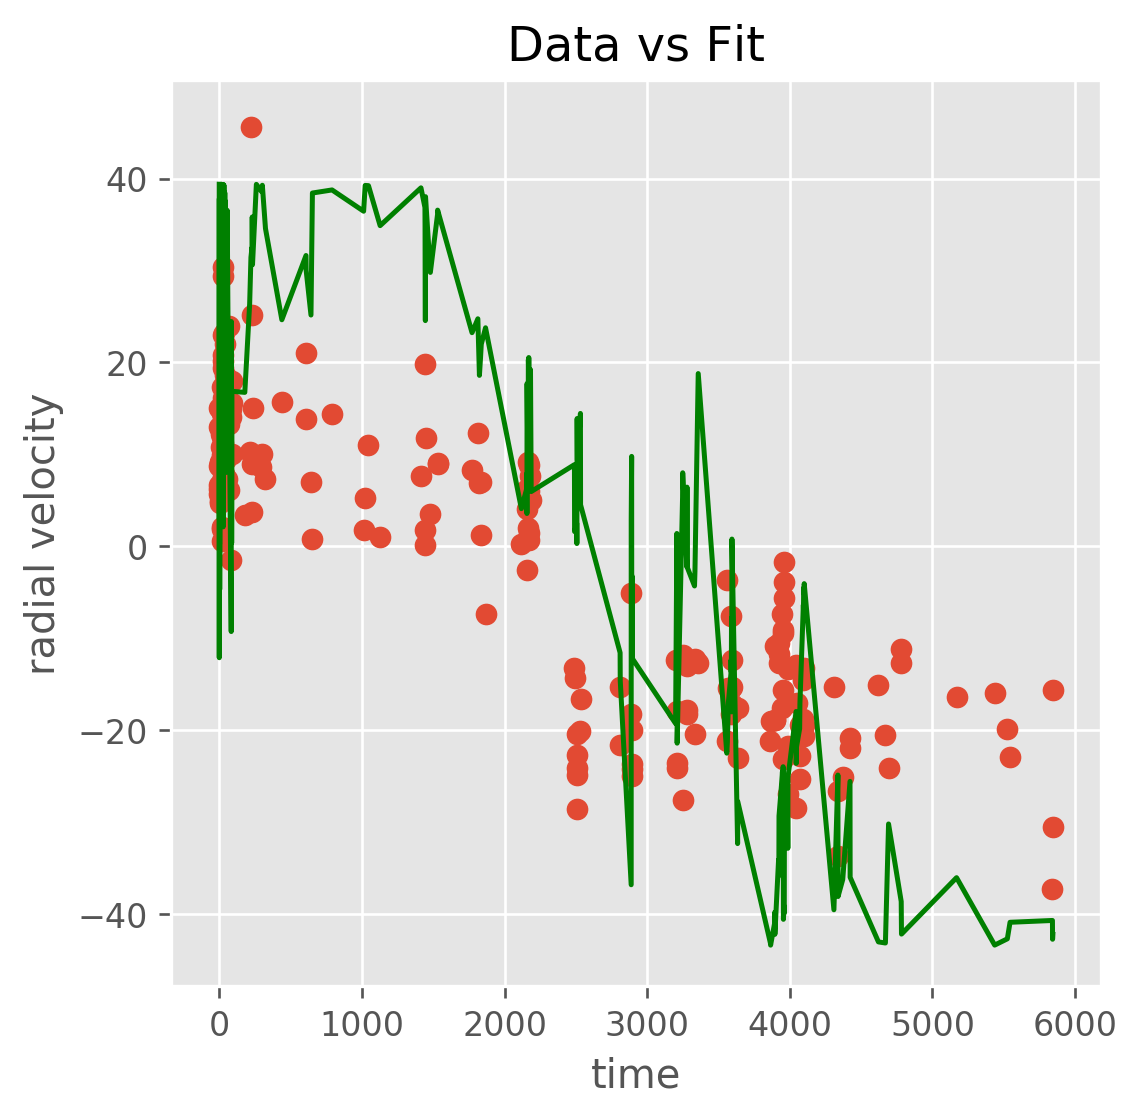

<Figure size 600x600 with 0 Axes>

In [16]:
if eccentricity == True:

    e_guesses = np.linspace(0,0.99,25)
    w_guesses = np.linspace(0,np.pi*2,25)
    tp_guesses = np.linspace(0,Pguess,25)

    e = e_guesses[0]
    w = w_guesses[0]
    t_p = tp_guesses[0]

    v_o,K= np.mean(y),(np.max(y)-np.min(y))*0.5


    r_v = []
    for j in x:
        M = mean_anomaly(Pguess,j,t_p)
        i = 0
        xi = M
        yy = abs(f(xi,e,M))
        while yy > tol and i < max_iter:
            xi = newt_step(xi,e,M)
            yy = abs(f(xi,e,M))
            i += 1
        E = xi
        f_a = true_anomaly(E,e)
        r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))

    chi = weighted_chi2_errors(r_v,y,errors)
    print('pre MCMC chi', chi)

    for ii in e_guesses:
        for jj in w_guesses:
            for kk in tp_guesses:
                initial_guesses = Pguess,np.mean(y),(np.max(y)-np.min(y))*0.5,kk,jj,ii
                Pguess,v_o,K,kk,jj,ii = initial_guesses

                tfolded = x%Pguess

                r_v = []
                for j in x:
                    M = mean_anomaly(Pguess,j,kk)
                    i = 0
                    xi = M
                    yy = abs(f(xi,e,M))
                    while yy > tol and i < max_iter:
                        xi = newt_step(xi,e,M)
                        yy = abs(f(xi,e,M))
                        i += 1
                    E = xi
                    f_a = true_anomaly(E,ii)
                    r_v.append(ellip_rv(v_o,K,jj,ii,j,kk,Pguess))

                new_chi = weighted_chi2_errors(r_v,y,errors)

                if new_chi < chi:
                    chi = new_chi
                    best_e = ii
                    best_w = jj
                    best_tp = kk

    e = best_e
    w = best_w
    t_p = best_tp

    r_v = []
    for j in x:
        M = mean_anomaly(Pguess,j,t_p)
        E,check = newt_loop(tol,max_iter,M,e)
        f_a = true_anomaly(E,e)
        r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))

    pre_mcmc = chi,Pguess,v_o,t_p,K,e,w

if eccentricity == False:

    tfolded = x%Pguess
    v_o = np.mean(y)
    K = (np.max(y)-np.min(y))*0.5
    tp_guesses = np.linspace(0,Pguess,25)
    tptp = tp_guesses[0]

    r_v = circ_rv(v_o,tptp,K,Pguess,x)
    chi = weighted_chi2_errors(r_v,y,errors)


    for tptp in tp_guesses:

        r_v = circ_rv(v_o,tptp,K,Pguess,x)
        new_chi = weighted_chi2_errors(r_v,y,errors)
        if new_chi < chi:
            chi = new_chi
            best_tp = tptp

    t_p = best_tp

    pre_mcmc = chi,Pguess,v_o,t_p,K
print(pre_mcmc)
plt.scatter(tfolded,r_v,label='fit',color='red')
plt.scatter(tfolded,y,label='data',color='green')
plt.xlabel('phase folded time')
plt.ylabel('radial velocity')
plt.title('Radial Velocity (ms) v Phase Folded Time (days)')
plt.legend()

plt.figure()

plt.scatter(x,r_v,label='fit',color='red')
plt.scatter(x,y,label='data',color='green')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.title('Radial Velocity (ms) v Time (days)')
plt.legend()

plt.figure()

plt.plot(x,r_v,'g-',label = 'fit')
plt.scatter(x,y,label='data')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.title('Data vs Fit')

plt.figure()

print(f'Current chi: {chi}')

P:0.9972201801492121,K:41.39864268633153,t_p:0.04155720418892386,v_o:-2.004154888517521
0.0%


10.0%
20.0%


30.0%
40.0%
50.0%


60.0%


70.0%
80.0%


90.0%


No handles with labels found to put in legend.


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


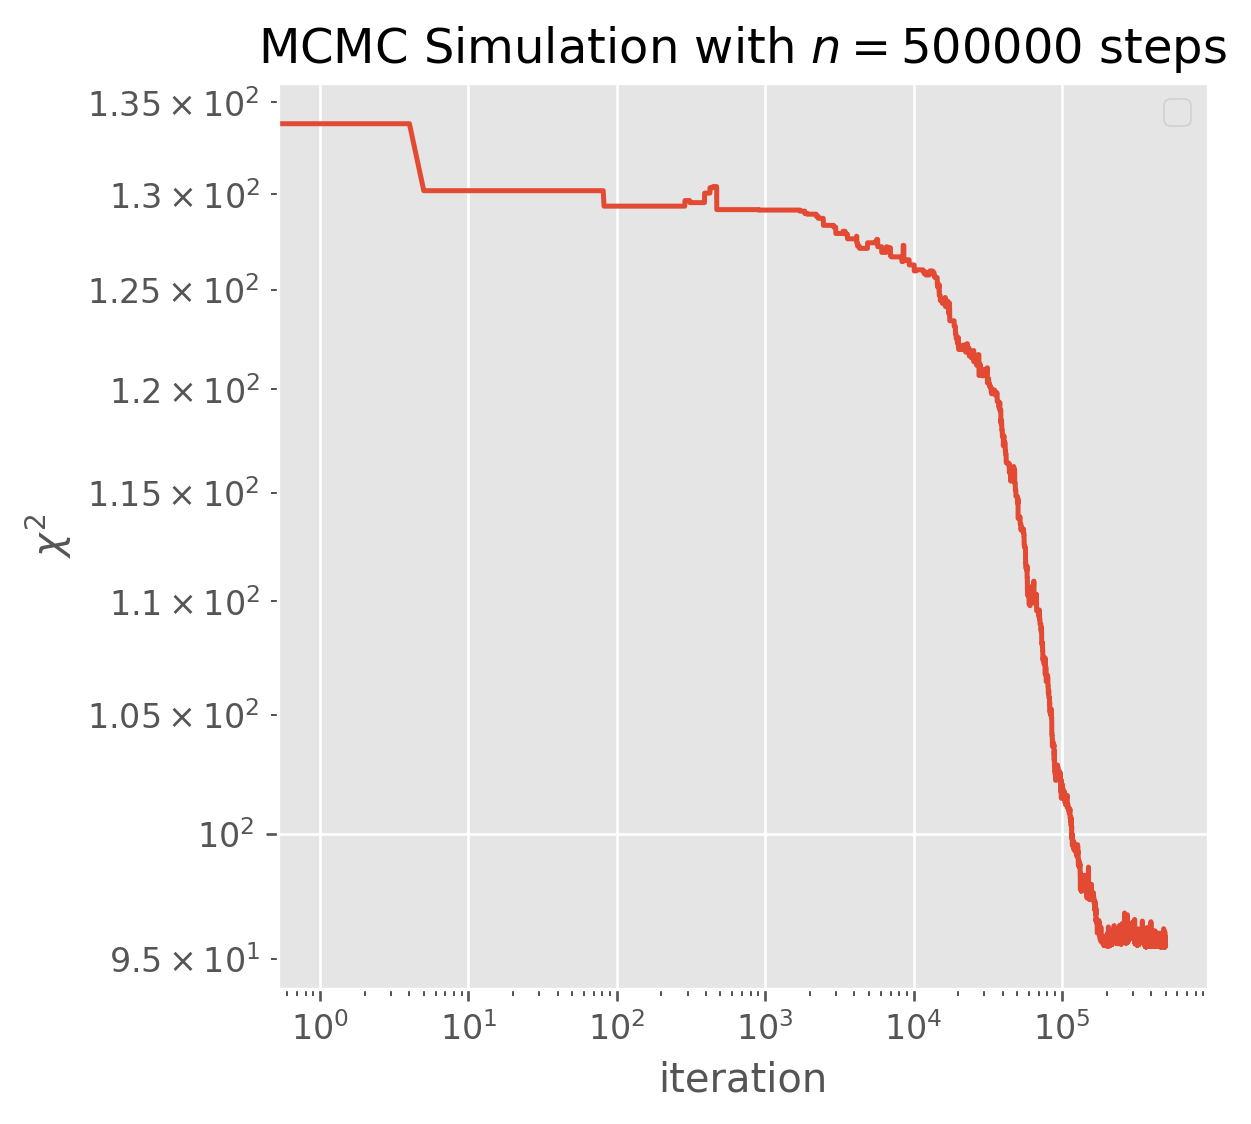

No handles with labels found to put in legend.


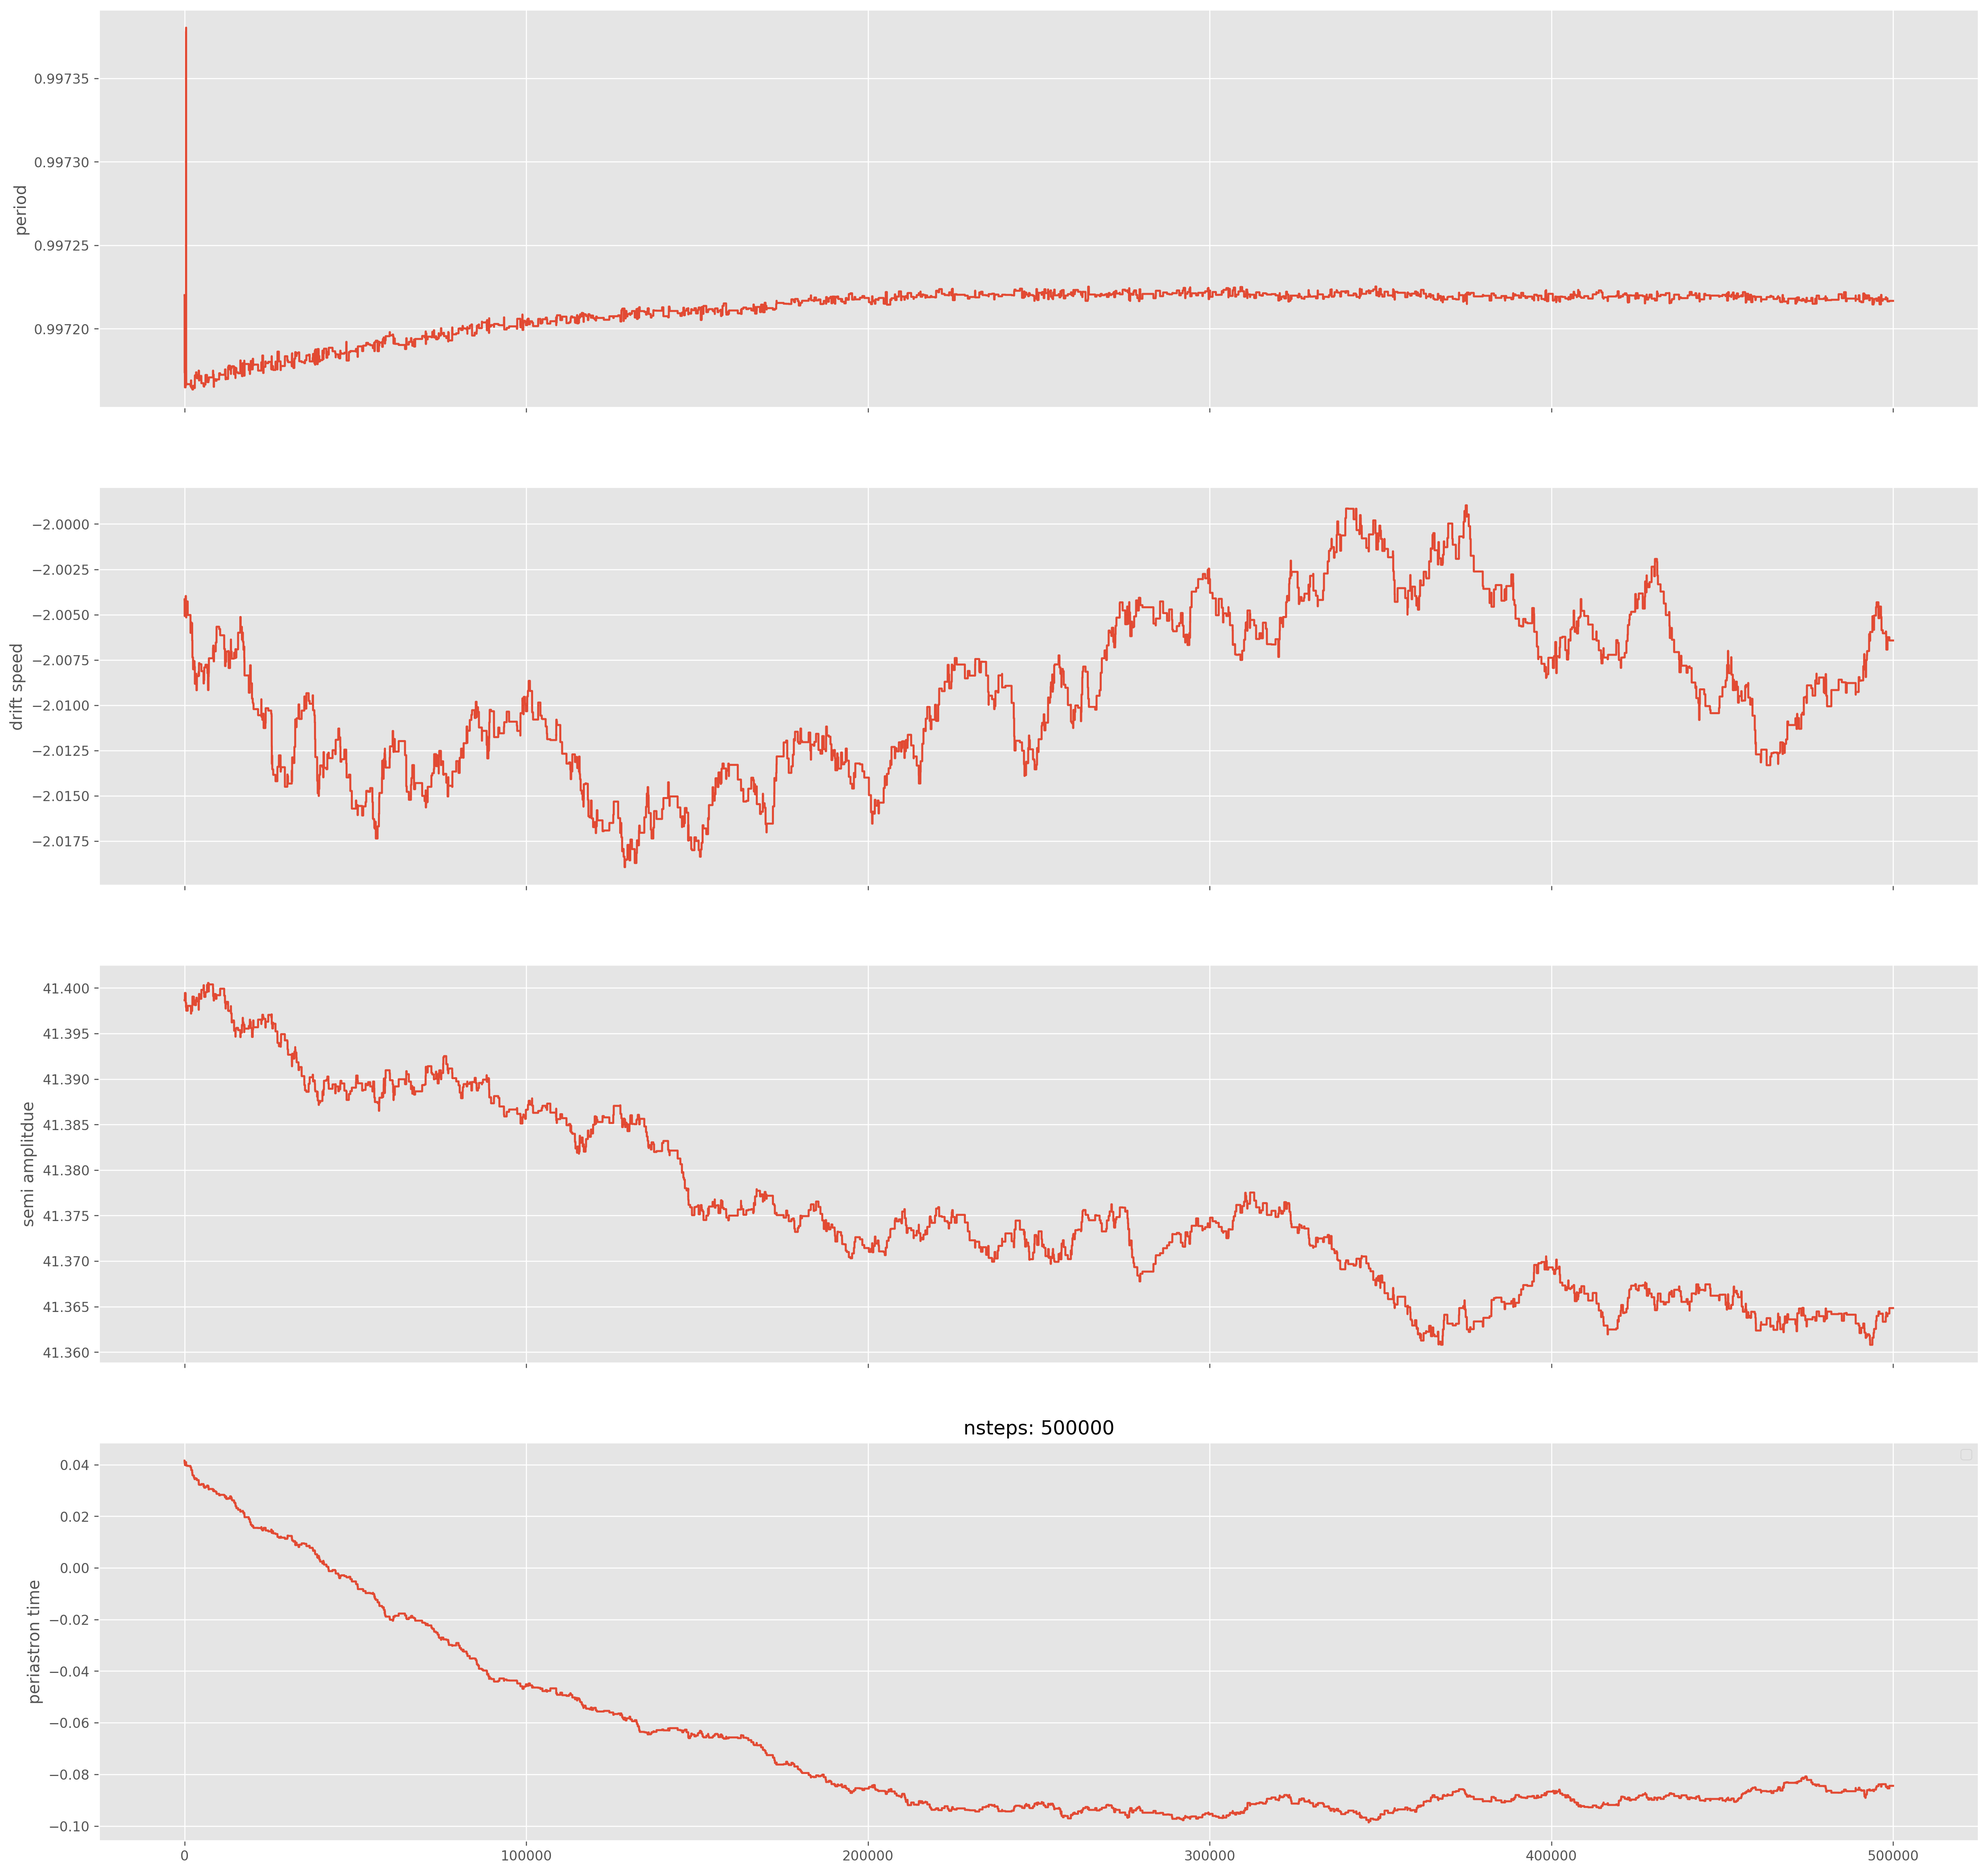

<Figure size 600x600 with 0 Axes>

In [30]:
from numpy.random import random, seed
beta = 5 #acceptance parameter
RCv = 1000
RCk = 1000
RCt = 1000
RCp = 1000
sigfig = 10
RCe = 1000
RCw = 50
T_p = t_p

loading = np.linspace(0,n_steps,11)
print(f'P:{Pguess},K:{K},t_p:{T_p},v_o:{v_o}')

# define chi from starting values
chi = weighted_chi2_errors(r_v,y,errors)

if eccentricity == False:
    # lists for steps taken during mcmc
    Pguesses=[Pguess]
    v_os = [v_o]
    Ks = [K]
    T_ps = [T_p]
    chis = [chi]

    for i in range(n_steps):
        if i in loading:
            print(f'{(i/n_steps)*100}%')
        v_o_step = np.random.uniform(-v_o/(RCv*v_o),v_o/(RCv*v_o))
        K_step = np.random.uniform(-K/(RCk*K),K/(K*RCk))
        T_p_step = np.random.uniform(-T_p/(T_p*RCt),T_p/(T_p*RCt))
        P_step = np.random.uniform(-Pguess/(Pguess*RCp),Pguess/(Pguess*RCp))

        new_p = P_step + Pguess
        new_v = v_o_step + v_o
        new_k = K_step + K
        new_Tp = T_p_step + T_p
        new_rv = circ_rv(new_v,new_Tp,new_k,new_p,x)

        new_chi = weighted_chi2_errors(new_rv,y,errors)

        if chi>new_chi:
            Pguess,v_o,K,T_p,chi = new_p,new_v,new_k,new_Tp,new_chi  

        else:
            a = random()
            odds = np.exp(-beta*(new_chi-chi))
            # print(f'random number: {a}, odds: {odds}')
            if a < odds:
                Pguess,v_o,K,T_p,chi = new_p,new_v,new_k,new_Tp,new_chi
                odds_counter = odds_counter + 1

        Pguesses.append(Pguess)
        v_os.append(v_o)
        Ks.append(K)
        T_ps.append(T_p)
        chis.append(chi)
        #print()
    plt.title(f"MCMC Simulation with $n = {n_steps}$ steps")
    plt.xlabel('iteration')
    plt.ylabel('$\chi^2$')
    plt.loglog(chis)
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(4,sharex=True,figsize=(25,25))
    plt.gca().set_title(f'nsteps: {n_steps}')
    axs[0].plot(Pguesses)
    axs[1].plot(v_os)
    axs[2].plot(Ks)
    axs[3].plot(T_ps)
    labels = ['period','drift speed','semi amplitdue','periastron time']
    i=0
    for ax in axs:
        ax.set(ylabel=labels[i])
        i+=1
    plt.legend()
    plt.figure()

if eccentricity == True:
    # lists for steps taken during mcmc
    Pguesses=[Pguess]
    v_os = [v_o]
    Ks = [K]
    T_ps = [T_p]
    ws = [w]
    es = [e]
    chis = [chi]

    for i in range(n_steps):
        if i in loading:
            print(f'{(i/n_steps)*10000}%')
        v_o_step = np.random.uniform(-v_o/(RCv*v_o),v_o/(RCv*v_o))
        K_step = np.random.uniform(-K/(RCk*K),K/(K*RCk))
        T_p_step = np.random.uniform(-T_p/(T_p*RCt),T_p/(T_p*RCt))
        P_step = np.random.uniform(-Pguess/(Pguess*RCp),Pguess/(Pguess*RCp))
        e_step = np.random.uniform(-e/(e*RCe),e/(e*RCe))
        w_step = np.random.uniform(-w/(w*RCw),w/(w*RCw))

        new_p = P_step + Pguess
        new_v = v_o_step + v_o
        new_k = K_step + K
        new_Tp = T_p_step + T_p
        new_e = e_step + e
        new_w = w_step + w

        if new_e < 0:
            new_e = 1/2
        if new_e >= 1:
            new_e = 1-(1/new_e)
        if new_Tp > Pguess:
            new_Tp = Pguess - (1/new_Tp)
        if new_Tp < 0:
            new_Tp = abs(new_Tp)/2

        new_rv = []
        counter = 0
        try:
            for j in x:
                M = mean_anomaly(new_p,j,new_Tp)
                E,check = newt_loop(tol,max_iter,M,new_e)
                f_a = true_anomaly(E,new_e)
                new_rv.append(ellip_rv(new_v,new_k,new_w,new_e,j,new_Tp,new_p))
                counter += 1

        except ValueError:
            print(new_p,j,new_Tp,M,E,check,f_a)

        new_chi = weighted_chi2_errors(new_rv,y,errors)

        if chi>new_chi:
            Pguess,v_o,K,T_p,chi,w,e = new_p,new_v,new_k,new_Tp,new_chi,new_w,new_e

        else:
            a = random()
            odds = np.exp(-beta*(new_chi-chi))
            # print(f'random number: {a}, odds: {odds}')
            if a < odds:
                Pguess,v_o,K,T_p,chi,w,e = new_p,new_v,new_k,new_Tp,new_chi,new_w,new_e
                odds_counter = odds_counter + 1

        Pguesses.append(Pguess)
        v_os.append(v_o)
        Ks.append(K)
        T_ps.append(T_p)
        chis.append(chi)
        ws.append(w)
        es.append(e)
        #print()


    plt.title(f"MCMC Simulation with $n = {n_steps}$ steps")
    plt.xlabel('iteration')
    plt.ylabel('$\chi^2$')
    plt.loglog(chis)
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(6,sharex=True,figsize=(25,25))
    plt.gca().set_title(f'nsteps: {n_steps}')
    axs[0].plot(Pguesses)
    axs[1].plot(v_os)
    axs[2].plot(Ks)
    axs[3].plot(T_ps)
    axs[4].plot(es)
    axs[5].plot(ws)
    labels = ['period','drift speed','semi amplitdue','periastron time','eccentricity','orbital inclination,']
    i=0
    for ax in axs:
        ax.set(ylabel=labels[i])
        i+=1
    plt.legend()
    plt.figure()

In [32]:
if eccentricity == True:
    # as a note, making the

    islice = int(n_steps/10)*2
    chiPost = chis[islice:]
    PguessPost = Pguesses[islice:]
    v_osPost = v_os[islice:]
    T_psPost = T_ps[islice:]
    ksPost = Ks[islice:]
    KsPost = Ks[islice:]
    Kspost = Ks[islice:]
    kspost = Ks[islice:]
    espost = es[islice:]
    wspost = ws[islice:]

    minarg = np.argmin(chi)

    print(f'minimum value of chi during mcmc was: {np.min(chiPost)}')
    print(f'fitting parameters were: \n',PguessPost[minarg],v_osPost[minarg],T_psPost[minarg],KsPost[minarg],espost[minarg],wspost[minarg])
    print('as: period, drift speed, periastron, semi amplitude,eccentricity,inclination')
if eccentricity == False:
    islice = int(n_steps/10)*2
    chiPost = chis[islice:]
    PguessPost = Pguesses[islice:]
    v_osPost = v_os[islice:]
    T_psPost = T_ps[islice:]
    KsPost = Ks[islice:]

    minarg = np.argmin(chi)

    print(f'minimum value of chi during mcmc was: {np.min(chiPost)}')
    print(f'fitting parameters were: \n',PguessPost[minarg],v_osPost[minarg],T_psPost[minarg],KsPost[minarg])
    print('as: period, drift speed, periastron, semi amplitude')

minimum value of chi during mcmc was: 95.44387831780516
fitting parameters were: 
 0.9972021826747903 -2.0103329538899772 -0.04511736888054352 41.3866208478443
as: period, drift speed, periastron, semi amplitude


95.61575894828181


<Figure size 600x600 with 0 Axes>

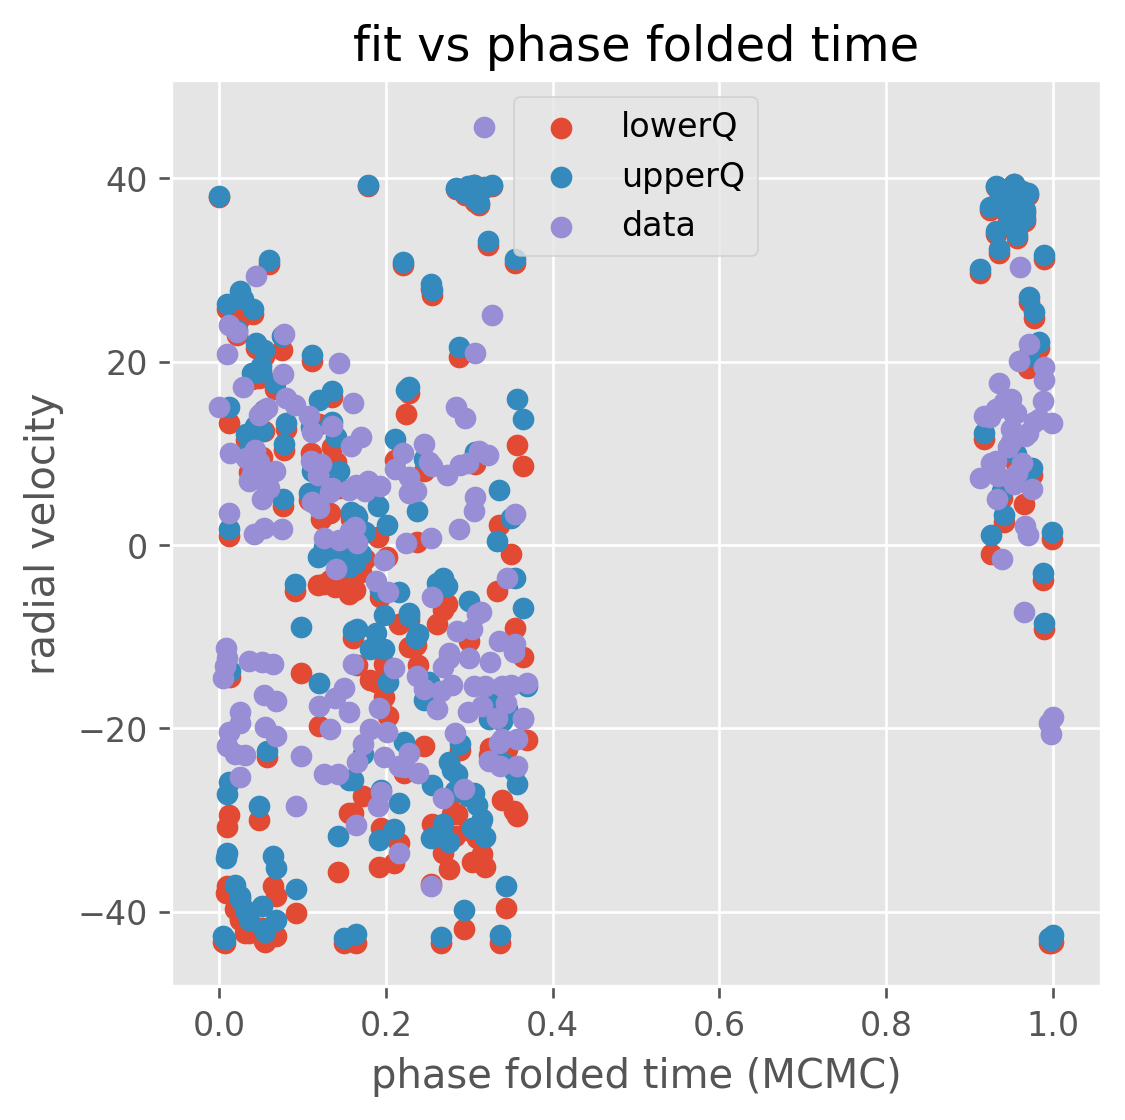

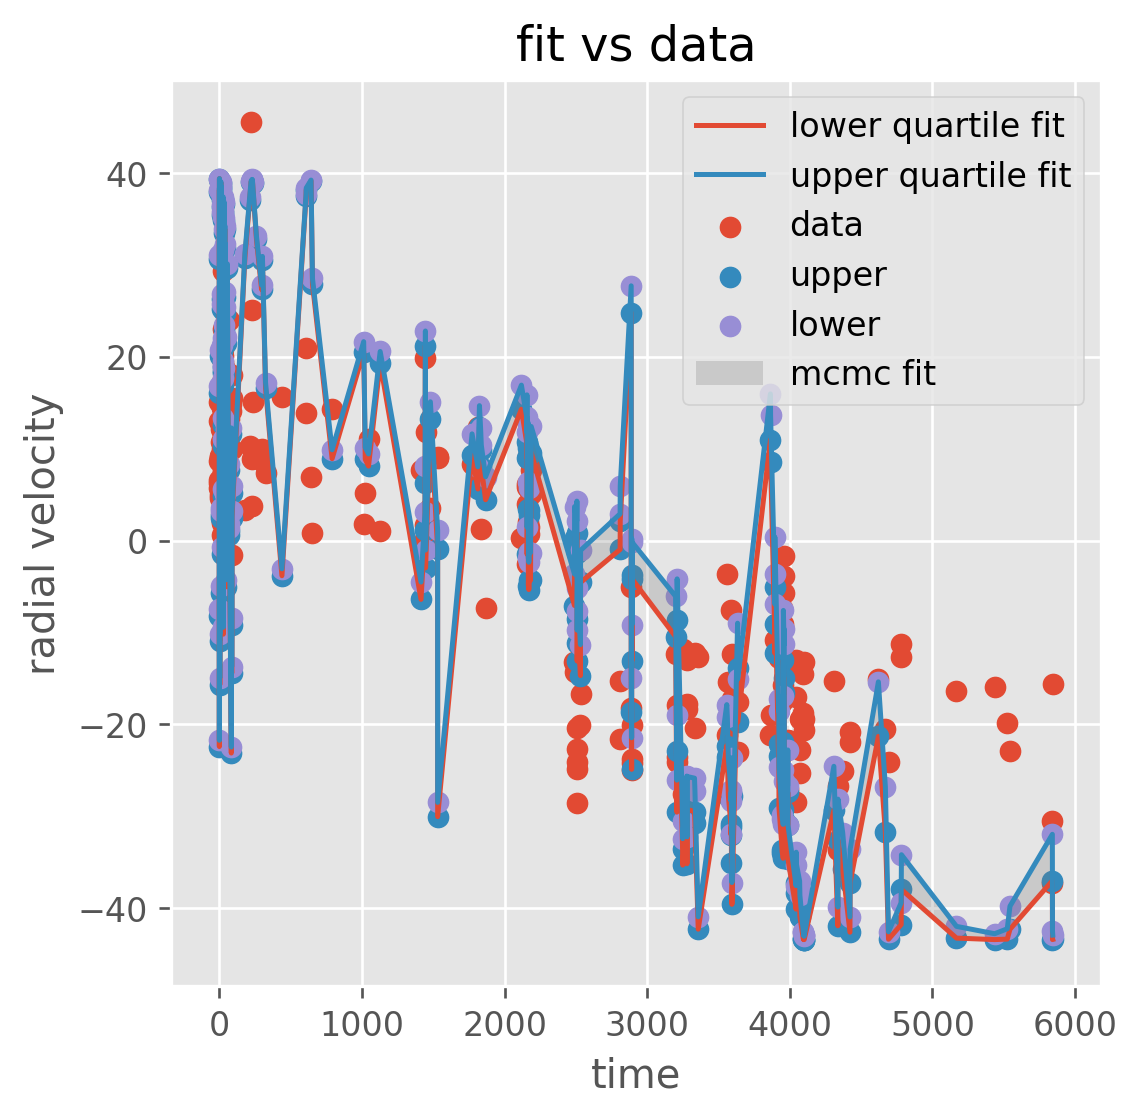

<Figure size 600x600 with 0 Axes>

In [29]:
chi_min = np.argmin(chiPost)
print(chiPost[chi_min])
Vaccurate = v_osPost[chi_min]
Kaccurate = KsPost[chi_min]
Paccurate = PguessPost[chi_min]
Taccurate = T_psPost[chi_min]
if eccentricity == True:
    Eaccurate = espost[chi_min]
    Waccurate = wspost[chi_min]

tfolded = x%Paccurate

models = []
if eccentricity == True:
    for i in range(n_curves):
        v_o,K,w,e,t_p,Pguess = v_osPost[i*spacing],KsPost[i*spacing],wspost[i*spacing],espost[i*spacing],T_psPost[i*spacing],PguessPost[i*spacing]
        r_v = []
        for j in x:
            M = mean_anomaly(Pguess,j,t_p)
            i = 0
            xi = M
            yy = abs(f(xi,e,M))
            while yy > tol and i < max_iter:
                xi = newt_step(xi,e,M)
                yy = abs(f(xi,e,M))
                i += 1
            E = xi
            f_a = true_anomaly(E,e)
            r_v.append(ellip_rv(v_o,K,w,e,j,t_p,Pguess))
        models.append(r_v)

if eccentricity == False:
    models = np.array([circ_rv(v_osPost[i*spacing], T_psPost[i*spacing], KsPost[i*spacing], PguessPost[i*spacing],x)
                   for i in range(n_curves)])

model_lowerq = np.quantile(models, 0.025, axis=0)
model_upperq = np.quantile(models, 0.975, axis=0)
model_avg    = np.quantile(models,0.5,axis=0)

plt.scatter(tfolded,model_lowerq,label='lowerQ')
plt.scatter(tfolded,model_upperq,label='upperQ')
plt.scatter(tfolded,y,label='data')
plt.title('fit vs phase folded time')
plt.xlabel('phase folded time (MCMC)')
plt.ylabel('radial velocity')
plt.legend()
plt.figure()

plt.scatter(x,y,label='data')
plt.scatter(x,model_lowerq,label='upper')
plt.scatter(x,model_upperq,label='lower')
plt.plot(x,model_lowerq,label='lower quartile fit')
plt.fill_between(x,model_lowerq,model_upperq,label='mcmc fit',alpha=0.25)
plt.plot(x,model_upperq,label='upper quartile fit')
plt.title('fit vs data')
plt.xlabel('time')
plt.ylabel('radial velocity')
plt.legend()
plt.figure()

best chi squared: 95.61575894828181
best drift speed: -2.011540881185877
best periastron time: -0.08721230206134152
best velocity semi amplitude: 41.39923627048802
best period: 0.9972187481351852
semi major in AU hopefully: 0.019793172485049856
msine factor: 8.970840428645736e+24


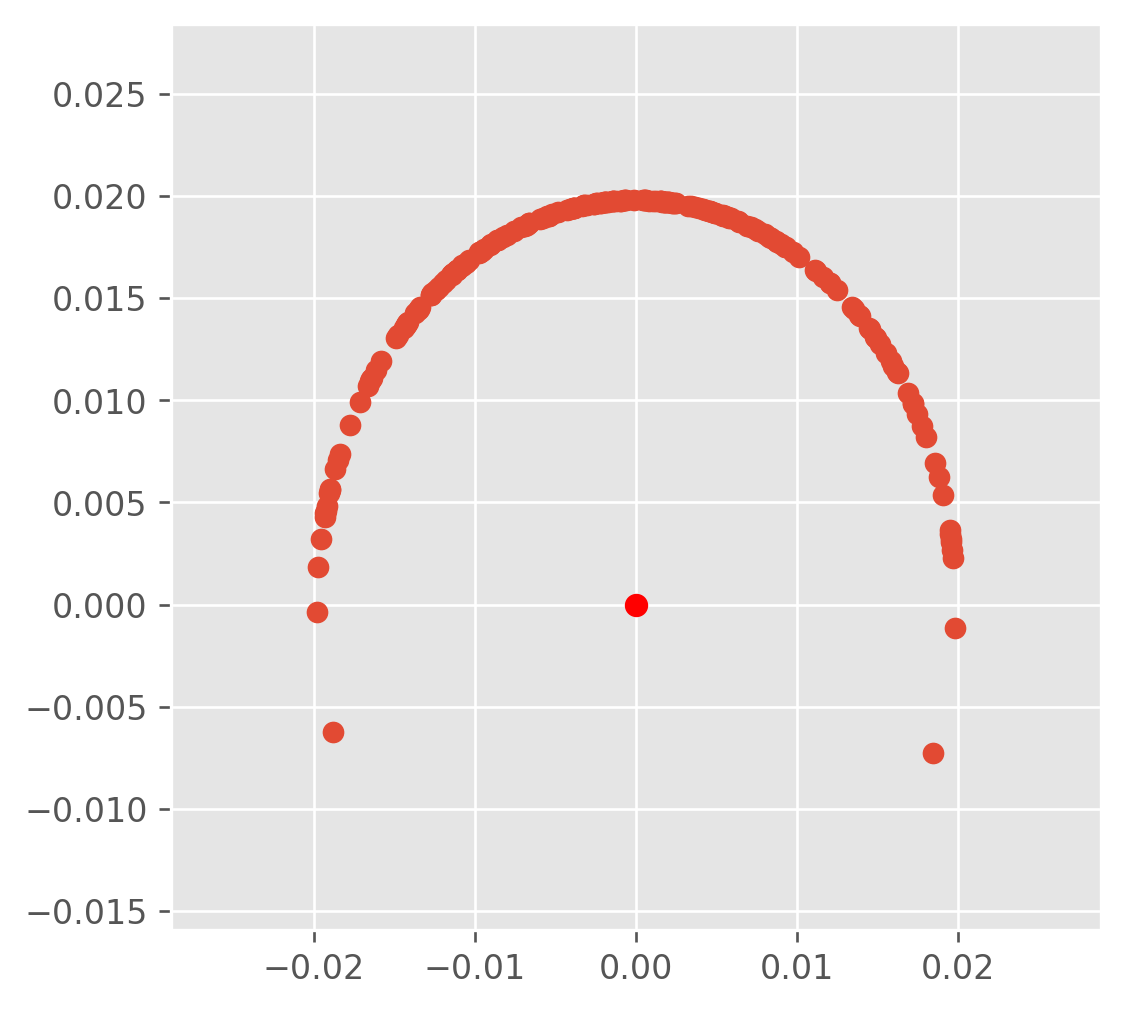

In [20]:
# v_o average drift speed
# t is time in days,
# T_p is the time when the orbit goes through periastron,
# K is the velocity semi-amplitude of the orbital motion in metres per second, and
# P is the orbital period of the orbit in days
plt.style.use('ggplot')
print(f'best chi squared: {chiPost[chi_min]}')
print(f'best drift speed: {Vaccurate}')
print(f'best periastron time: {Taccurate}')
print(f'best velocity semi amplitude: {Kaccurate}')
print(f'best period: {Paccurate}')
if eccentricity == True:
    print(f'best eccentricity: {Eaccurate}')
    print(f'best orbital inclination angle: {Waccurate}')

# FIX ME THEN SAVE ME TO DATAFILE
# fix / experiment with residual lomb scargle
# MAKE PLottiNG IN 1  FUNCTION
# ANALYZE RESIDUAL DATA

def semimajor(stellar_mass, p):
    G = 6.67430e-11 # gravitational constant in m^3/kg/s^2
    M_sun = 1.989*10**30 # mass of the sun in kg**
    AU = 149597870700 # astronomical unit in meters

    # Convert star_mass from solar masses to kg

    star_mass_kg = stellar_mass * M_sun

    # Convert period from days to seconds
    period_s = p * 24 * 3600
    # Calculate the semimajor axis using Kepler's third law
    a = ((G * star_mass_kg * period_s**2)/(4 * math.pi**2))**(1/3)

    # Convert semimajor axis from meters to astronomical units
    a_au = a / AU

    return a_au

a = semimajor(m_star,Paccurate)

print(f'semi major in AU hopefully: {a}')

def msine(k,p,stellar_mass,e):
    m_sun = 1.989*10**30
    msine = K * (1/((2*np.pi*G)/p)**(1/3)) * (1-e**2)**(1/2) * (stellar_mass*m_sun)**(2/3)
    return msine

if eccentricity == False:
    print(f'msine factor: {msine(Kaccurate,Paccurate,m_star,0)}')
    post_mcmc = chiPost[chi_min],Paccurate,Vaccurate,Taccurate,Kaccurate
    
if eccentricity == True:
    print(f'msine factor: {msine(Kaccurate,Paccurate,m_star,Eaccurate)}')
    post_mcmc = chiPost[chi_min],Paccurate,Vaccurate,Taccurate,Kaccurate,Eaccurate,Waccurate


from matplotlib import pyplot as plt
import math
import numpy as np

def radial(a, e, f):
    # Calculate the radial distance
    r = a*(1 - e**2)/(1 + e*math.cos(f))
    return r

def cartesian(r,f):
    # Calculate the cartesian coordinates
    x = r*math.cos(f)
    y = r*math.sin(f)
    return x, y


xlist = []
ylist = []

if eccentricity == False:
    Eaccurate = 0

for j in x:
    M = mean_anomaly(Paccurate,j,Taccurate)
    i = 0
    xi = M
    yy = abs(f(xi,Eaccurate,M))
    while yy > tol and i < max_iter:
        xi = newt_step(xi,Eaccurate,M)
        yy = abs(f(xi,Eaccurate,M))
        i += 1
    E = xi
    f_a = true_anomaly(E,Eaccurate)
    r = radial(a,Eaccurate,f_a)
    xcoord,ycoord = cartesian(r,f_a)
    xlist.append(xcoord)
    ylist.append(ycoord)

plt.rcParams['figure.figsize'] = (5,5)
#xlist,ylist,rlist = eccorbit(Paccurate,x[-1],x[-1]*10,0.7,m,Taccurate)
plt.scatter(xlist,ylist)
plt.plot(0,0,'ro',label='origin')
plt.show()
#aw yea